In [2]:
#Setup - define all functions
%matplotlib notebook
import numpy as np
from numpy import *
from glob import glob
import h5py
import shutil
import os
import sys
from os import path, mkdir
home = path.expanduser("~")
import matplotlib.pyplot as plt
plt.style.use('/Users/schenke/projects/CYM/RpA/csplotstyle')
sys.path.append(os.path.abspath("/Users/schenke/projects/CYM/RpA"))
working_path = path.abspath('/Users/schenke/projects/CYM/Derek/')
from CSplottools import getPlotElements
width = 0.5
plotMarkerSize = 8


def compute_ep(output_data, N):
    eden  = output_data[:,3]
    eden  = np.reshape(eden,(N,N))
    uxarr = output_data[:,5]
    uxarr = np.reshape(uxarr,(N,N))
    uyarr = output_data[:,6]
    uyarr = np.reshape(uyarr,(N,N))
    pixx  = output_data[:,12]
    pixx  = np.reshape(pixx,(N,N))
    piyy  = output_data[:,15]
    piyy  = np.reshape(piyy,(N,N))
    pixy  = output_data[:,13]
    pixy  = np.reshape(pixy,(N,N))

    eden = eden / 0.19732697
    TxxIdeal = 4./3.*eden*uxarr*uxarr + 1./3.*eden 
    TyyIdeal = 4./3.*eden*uyarr*uyarr + 1./3.*eden
    TxyIdeal = 4./3.*eden*uxarr*uyarr

    Txx = TxxIdeal + pixx
    Tyy = TyyIdeal + piyy
    Txy = TxyIdeal + pixy

    avgTxxmTyyId = np.sum((TxxIdeal - TyyIdeal))
    avgTxxpTyyId = np.sum((TxxIdeal + TyyIdeal))
    avg2TxyId    = np.sum((2.*TxyIdeal))

    avgTxxmTyy = np.sum((Txx - Tyy))
    avgTxxpTyy = np.sum((Txx + Tyy))
    avg2Txy    = np.sum((2.*Txy))

    epId = np.sqrt( (avgTxxmTyyId*avgTxxmTyyId+avg2TxyId*avg2TxyId)/(avgTxxpTyyId*avgTxxpTyyId) )
    ep = np.sqrt( (avgTxxmTyy*avgTxxmTyy+avg2Txy*avg2Txy)/(avgTxxpTyy*avgTxxpTyy) )
    ep_real = ep * cos(arctan2(avg2Txy,(avgTxxmTyy))) #cos 2 psi
    ep_imag = ep * sin(arctan2(avg2Txy,(avgTxxmTyy))) #sin 2 psi
    #ep_real_2 = ep * 1./(sqrt(1.+avg2Txy**2./avgTxxmTyy**2.))
    #ep_imag_2 = ep * avg2Txy/avgTxxmTyy/(sqrt(1.+avg2Txy**2./avgTxxmTyy**2.))

   # print(ep_real, ep_real_2)
   # print(ep_imag, ep_imag_2)
    return ep, ep_real, ep_imag

def compute_uT(output_data, N):
    eden  = output_data[:,3]
    eden  = np.reshape(eden,(N,N))
    uxarr = output_data[:,5]
    uxarr = np.reshape(uxarr,(N,N))
    uyarr = output_data[:,6]
    uyarr = np.reshape(uyarr,(N,N))
  
    uT = sum(sqrt(uxarr*uxarr+uyarr*uyarr)*eden)/sum(eden)
    
    return uT

def compute_meanr_meanr2_meanecc2(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 
    xarr = output_data[:,1]
    xarr = np.reshape(xarr,(N,N)) 
    yarr = output_data[:,2]
    yarr = np.reshape(yarr,(N,N)) 

    #shift
    xshift = np.sum(xarr*eden)/np.sum(eden)
    yshift = np.sum(yarr*eden)/np.sum(eden)
    xarr = xarr-xshift
    yarr = yarr-yshift

    #define radius and angle
    rarr = np.sqrt(xarr*xarr+yarr*yarr)
    phiarr = np.arctan2(yarr,xarr)

    #compute average radius of the event
    num = np.sum(rarr*eden)
    norm = np.sum(eden)
    r_ev = num/norm
    
    #compute rms radius (eccentricity part commented but can be used later)
    for n in range(2,3):
        #print("n=",n)
        rarrn=np.power(rarr,n)
        expinphi=np.exp(1.j*n*phiarr)
        num = np.sum(rarrn*expinphi*eden)
        den = np.sum(rarrn*eden)
        norm = np.sum(eden)
        evec = -num/den
        r2_ev = den/norm
        ecc_2_ev = np.abs(-num/den)
    return(r_ev, r2_ev, ecc_2_ev, (-num/den).real, (-num/den).imag)

def compute_meanr_meanr2_meanecc2_meanecc3(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 
    xarr = output_data[:,1]
    xarr = np.reshape(xarr,(N,N)) 
    yarr = output_data[:,2]
    yarr = np.reshape(yarr,(N,N)) 

    #shift
    xshift = np.sum(xarr*eden)/np.sum(eden)
    yshift = np.sum(yarr*eden)/np.sum(eden)
    xarr = xarr-xshift
    yarr = yarr-yshift

    #define radius and angle
    rarr = np.sqrt(xarr*xarr+yarr*yarr)
    phiarr = np.arctan2(yarr,xarr)

    #compute average radius of the event
    num = np.sum(rarr*eden)
    norm = np.sum(eden)
    r_ev = num/norm
    
    #compute rms radius (eccentricity part commented but can be used later)
    for n in range(2,3):
        #print("n=",n)
        rarrn=np.power(rarr,n)
        expinphi=np.exp(1.j*n*phiarr)
        num = np.sum(rarrn*expinphi*eden)
        den = np.sum(rarrn*eden)
        norm = np.sum(eden)
        evec = -num/den
        r2_ev = den/norm
        ecc_2_ev = np.abs(-num/den)
        
    for n in range(3,4):
        #print("n=",n)
        rarrn=np.power(rarr,n)
        expinphi=np.exp(1.j*n*phiarr)
        num = np.sum(rarrn*expinphi*eden)
        den = np.sum(rarrn*eden)
        norm = np.sum(eden)
        evec = -num/den
        r2_ev = den/norm
        ecc_3_ev = np.abs(-num/den)
        
    return(r_ev, r2_ev, ecc_2_ev, ecc_3_ev)

def compute_entropy_area(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 
    xarr = output_data[:,1]
    xarr = np.reshape(xarr,(N,N)) 
    yarr = output_data[:,2]
    yarr = np.reshape(yarr,(N,N)) 

    #shift
    xshift = np.sum(xarr*eden)/np.sum(eden)
    yshift = np.sum(yarr*eden)/np.sum(eden)
    xarr = xarr-xshift
    yarr = yarr-yshift

    #define radius and angle
    xarr2 = np.sum(xarr*xarr*eden)
    yarr2 = np.sum(yarr*yarr*eden)
    norm =  np.sum(eden)
    
    xarr2 = xarr2/norm
    yarr2 = yarr2/norm
        
    return(norm**(2./3.), xarr2*yarr2)

#average entropy density:
def compute_entropy_density_avg(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 

    norm =  np.sum(eden)
    
    s_avg = np.sum(eden**(2./3.)*eden)
    
    s_avg = s_avg/norm
        
    return(s_avg)

#rms entropy density:
def compute_entropy_density_rms(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 

    norm =  np.sum(eden)
    
    s_avg = np.sum(eden**(4./3.)*eden)
    
    s_avg = sqrt(s_avg/norm)
        
    return(s_avg)

#avg energy density:
def compute_energy_density_avg(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 

    norm =  np.sum(eden)
    
    s_avg = np.sum(eden*eden)
    
    s_avg = s_avg/norm
        
    return(s_avg)

#alternative area definition:
def compute_entropy_area_2(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,3]
    eden = np.reshape(eden,(N,N)) 
    utau = np.reshape(output_data[:,4],(N,N))

    norm =  np.sum(eden)
    entropy = np.sum(eden**(2./3.)*utau)
    
    eden_min = eden[eden>0.05*mean(eden)]
    
    area = eden_min.size/N
        
    return(entropy, area)

def compute_energy(output_data, N):
    # 1:x 2:y 3:energy density 
    eden = output_data[:,18] #using T00
    eden = np.reshape(eden,(N,N)) 

    norm =  np.sum(eden)
        
    return(norm)


def return_dNdy(data_path, centrality, particle_id):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
            
    print("we have",nev,"events")

    if particle_id == 9999:
        file_name = 'particle_%s_vndata_eta_-0.5_0.5.dat' % particle_id
    else:
        file_name = 'particle_%s_vndata_y_-0.5_0.5.dat' % particle_id

    dN_dy = []
    IDlist = []
    #print("start=",start) 
    idx = start  
    counter = 0
   
    while idx < start+nev: 
        #print("idx=",idx)
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 1):
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1   
            #print(event_name)
            #print(event_group)
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                IDlist.append(counter-1)
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                dN_dy.append(temp_data[0, 1])
                #print(temp_data[0, 1])
                idx += 1
        
    dN_dy = array(dN_dy) # this has the event by event multiplicity
    dN_dy_avg = mean(dN_dy) # event averaged multiplicity
    dN_dy_avg_err = std(dN_dy)/sqrt(nev) # standard deviation assuming a Poisson distribution
    return(dN_dy,dN_dy_avg,dN_dy_avg_err,IDlist,nev)

def return_v2(data_path, centrality, particle_id):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    if particle_id == 9999:
        file_name = 'particle_%s_vndata_eta_-0.5_0.5.dat' % particle_id
    else:
        file_name = 'particle_%s_vndata_y_-0.5_0.5.dat' % particle_id
    v2 = []
    
    idx = start  
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                v2.append(np.sqrt(temp_data[2, 1]**2.+temp_data[2, 3]**2.))
                idx += 1
            
    v2 = array(v2) # this has the event by event multiplicity
    v2_avg = mean(v2) # event averaged multiplicity
    v2sq_avg = mean(v2**2.)
    return(v2,v2_avg,v2sq_avg,nev)

def return_v3(data_path, centrality, particle_id):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    file_name = 'particle_%s_vndata_eta_-0.5_0.5.dat' % particle_id
   
    v3 = []
    
    idx = start 
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                v3.append(np.sqrt(temp_data[3, 1]**2.+temp_data[3, 3]**2.))
                idx += 1
            
    v3 = array(v3) # this has the event by event multiplicity
    v3_avg = mean(v3) # event averaged multiplicity
    v3sq_avg = mean(v3**2.)
    return(v3,v3_avg,v3sq_avg,nev)


def return_v2_complex(data_path, centrality, particle_id):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    file_name = 'particle_%s_vndata_eta_-0.5_0.5.dat' % particle_id
   
    v2_real = []
    v2_imag = []
    
    idx = start
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                v2_real.append(temp_data[2, 1])
                v2_imag.append(temp_data[2, 3])
                idx += 1
            
    v2_real = array(v2_real)
    v2_imag = array(v2_imag)
    return(v2_real, v2_imag, nev)



def calcualte_inte_vn(pT_low, pT_high, n_order, data):
    """
        this function calculates the pT-integrated vn in a 
        given pT range (pT_low, pT_high) for every event in the data
    """
    npT = 50
    pT_inte_array = linspace(pT_low, pT_high, npT)
    dpT = pT_inte_array[1] - pT_inte_array[0]
    dN_event = data[:, 2]
    pT_event = data[:, 0]
    dN_interp = exp(interp(pT_inte_array, pT_event, log(dN_event+1e-30)))
    N_event = data[:, -1]
    N_interp = exp(interp(pT_inte_array, pT_event, log(N_event+1e-30)))
    N = sum(N_interp)*dpT/0.1
    temp_vn_array = []
    vn_real_event = data[:, 4*n_order]
    vn_imag_event = data[:, 4*n_order+2]
    vn_real_interp = interp(pT_inte_array, pT_event, vn_real_event)
    vn_imag_interp = interp(pT_inte_array, pT_event, vn_imag_event)
    vn_real_inte = (
        sum(vn_real_interp*dN_interp*pT_inte_array)
        /sum(dN_interp*pT_inte_array))
    vn_imag_inte = (
        sum(vn_imag_interp*dN_interp*pT_inte_array)
        /sum(dN_interp*pT_inte_array))
    #vn_inte = vn_real_inte + 1j*vn_imag_inte
    #vn_inte = np.sqrt(vn_real_inte**2. + vn_imag_inte**2.)
    #temp_vn_array.append(vn_inte)
    return(np.sqrt(vn_real_inte**2. + vn_imag_inte**2.))   

def calcualte_complex_inte_vn(pT_low, pT_high, n_order, data):
    """
        this function calculates the pT-integrated vn in a 
        given pT range (pT_low, pT_high) for every event in the data
    """
    npT = 50
    pT_inte_array = linspace(pT_low, pT_high, npT)
    dpT = pT_inte_array[1] - pT_inte_array[0]
    dN_event = data[:, 2]
    pT_event = data[:, 0]
    dN_interp = exp(interp(pT_inte_array, pT_event, log(dN_event+1e-30)))
    N_event = data[:, -1]
    N_interp = exp(interp(pT_inte_array, pT_event, log(N_event+1e-30)))
    N = sum(N_interp)*dpT/0.1
    temp_vn_array = []
    vn_real_event = data[:, 4*n_order]
    vn_imag_event = data[:, 4*n_order+2]
    vn_real_interp = interp(pT_inte_array, pT_event, vn_real_event)
    vn_imag_interp = interp(pT_inte_array, pT_event, vn_imag_event)
    vn_real_inte = (
        sum(vn_real_interp*dN_interp*pT_inte_array)
        /sum(dN_interp*pT_inte_array))
    vn_imag_inte = (
        sum(vn_imag_interp*dN_interp*pT_inte_array)
        /sum(dN_interp*pT_inte_array))
    #vn_inte = vn_real_inte + 1j*vn_imag_inte
    #vn_inte = np.sqrt(vn_real_inte**2. + vn_imag_inte**2.)
    #temp_vn_array.append(vn_inte)
    return(vn_real_inte,vn_imag_inte)   

def return_vn_with_pT_cuts(data_path, centrality, particle_id, n_order, pT_low, pT_high):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    file_name = 'particle_%s_vndata_diff_eta_-0.5_0.5.dat' % particle_id
   
    v2 = []
    
    idx = start  
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                temp_vn_array = calcualte_inte_vn(pT_low, pT_high, n_order, temp_data)
                v2.append(temp_vn_array)
                idx += 1
            
    v2 = array(v2) # this has the event by event multiplicity
    v2_avg = mean(v2) # event averaged multiplicity
    v2sq_avg = mean(v2**2.)
    return(v2,v2_avg,v2sq_avg,nev)

def return_complex_vn_with_pT_cuts(data_path, centrality, particle_id, n_order, pT_low, pT_high):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    file_name = 'particle_%s_vndata_diff_eta_-0.5_0.5.dat' % particle_id
   
    v2real = []
    v2imag = []
    
    idx = start  
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                temp_vn_real_array, temp_vn_imag_array = calcualte_complex_inte_vn(pT_low, pT_high, n_order, temp_data)
                v2real.append(temp_vn_real_array)
                v2imag.append(temp_vn_imag_array)
                idx += 1
            
    v2real = array(v2real) 
    v2imag = array(v2imag)
    return(v2real, v2imag, nev)

def return_v2_forward(data_path, centrality, particle_id):     
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    file_name = 'particle_%s_vndata_eta_0.5_2.dat' % particle_id
   
    v2 = []
    
    idx = start  
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data) #fix if there are nan's
                v2.append(np.sqrt(temp_data[2, 1]**2.+temp_data[2, 3]**2.))
                idx += 1
            
    v2 = array(v2) # this has the event by event multiplicity
    v2_avg = mean(v2) # event averaged multiplicity
    v2sq_avg = mean(v2**2.)
    return(v2,v2_avg,v2sq_avg,nev)


def return_dNdypTdpT_or_vnpT(data_path, centrality, particle_id,n):   # n=0 returns dN/(2pi dy pT dpT)      
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")

    if particle_id == 9999:
        file_name = 'particle_%s_vndata_diff_eta_-0.5_0.5.dat' % particle_id
    else:
        file_name = 'particle_%s_vndata_diff_y_-0.5_0.5.dat' % particle_id
        file_name2 = 'particle_-%s_vndata_diff_y_-0.5_0.5.dat' % particle_id

    pT_array = []
    dN_array = []
 
    idx = start 
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                if particle_id == 9999:
                    temp_data = event_group.get(file_name)
                    temp_data = nan_to_num(temp_data)
                    if n==0:
                        dN_event = temp_data[:, 2]
                    else:
                        dN_event = sqrt(temp_data[:, 4*n]**2. + temp_data[:, 4*n+2]**2.)
                else:
                    temp_data = event_group.get(file_name)
                    temp_data = nan_to_num(temp_data)
                    temp_data2 = event_group.get(file_name2)
                    temp_data2 = nan_to_num(temp_data2)
                    if n==0:
                        dN_event = (temp_data[:, 2]+temp_data2[:, 2])/2.  
                    else:
                        dN_event = (sqrt(temp_data[:, 4*n]**2. + temp_data[:, 4*n+2]**2.)+sqrt(temp_data2[:, 4*n]**2. + temp_data2[:, 4*n+2]**2.))/2.
                pT_event = temp_data[:, 0]

                # record particle spectra                                                                                                                                                                         
                pT_array.append(pT_event)
                dN_array.append(dN_event)
                idx += 1
                                                                                                                                                                       
    dN_array = array(dN_array)
    pT_array = array(pT_array)
    return(pT_array, dN_array)

def return_dNdypTdpT_or_vnpT_forward(data_path, centrality, particle_id, n):   # n=0 returns dN/(2pi dy pT dpT)      
    hf = h5py.File(data_path, "r")
    event_list = list(hf.keys())
    nevAll = len(event_list)
    nev=0
    for i in range((nevAll)):
        stringparts=list(hf)[i].split('_')
        stringparts.pop(-1)
        if (len(stringparts) > 4.):
            if stringparts[3]==centrality or stringparts[4]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
        else:
            if stringparts[3]==centrality:
                if (nev == 0):
                    start = i
                nev = nev+1
    print("we have",nev,"events")
    
    if particle_id == 9999:
        file_name = 'particle_%s_vndata_diff_eta_0.5_2.dat' % particle_id
    else:
        file_name = 'particle_%s_vndata_diff_y_0.5_2.dat' % particle_id

    pT_array = []
    dN_array = []
 
    idx = start 
    counter = 0
    while idx < start+nev: 
        stringparts=list(hf)[start].split('_')
        stringparts.pop(-1)
        if len(stringparts) > 1:
            new_string = stringparts[0]+"_"+stringparts[1]+"_"+stringparts[2]+"_"+stringparts[3]
            if (len(stringparts) > 4):    
                new_string = new_string+"_"+stringparts[4]
            event_name = new_string+"_{0:d}".format(counter)
            event_group = hf.get(event_name)
            counter += 1
            if event_group and (stringparts[3]==centrality or stringparts[4]==centrality):
                temp_data = event_group.get(file_name)
                temp_data = nan_to_num(temp_data)
                if n==0:
                    dN_event = temp_data[:, 2]  
                else:
                    dN_event = sqrt(temp_data[:, 4*n]**2. + temp_data[:, 4*n+2]**2.)
                pT_event = temp_data[:, 0]

                # record particle spectra                                                                                                                                                                         
                pT_array.append(pT_event)
                dN_array.append(dN_event) #do not normalize to 1 unit of rapidity (removed /1.5 on 03/06/2020)
                idx += 1
                                                                                                                                                                       
    dN_array = array(dN_array)
    pT_array = array(pT_array)
    return(pT_array, dN_array)
    
    
    #Tmunu-
    
def fetch_an_IPGlasma_event(database_path, time_stamp, event_idx):
    print(("fetching an IP-Glasma event with "
           + "event id: {} at tau = {} fm from {}".format(event_idx,
                                                          time_stamp,
                                                          database_path))
    )
    hf          = h5py.File(database_path, "r")
    event_name  = "event-{0:d}".format(event_idx)
    event_group = hf.get(event_name)
    
    file_name   = "epsilon-u-Hydro-t{0:s}-{1:d}.dat".format(time_stamp, event_idx)
    file_name2  = "Tmunu-t{0:s}-{1:d}.dat".format(time_stamp, event_idx)  
    temp_data   = event_group.get(file_name)
    temp_data2  = event_group.get(file_name2)
    data_header = temp_data.attrs["header"].decode('UTF-8').replace('#','')
    x_size      = temp_data.attrs["x_size"]
    y_size      = temp_data.attrs["y_size"]
    dx          = temp_data.attrs["dx"]
    dy          = temp_data.attrs["dy"]
    nx          = temp_data.attrs["nx"]
    ny          = temp_data.attrs["ny"]

    output_data = np.zeros([len(temp_data[:, 0]), 19])
    output_data[:, 3:-1] = temp_data  
    output_data[:, 18] = temp_data2[:,2]
   
    idx = 0
    for ix in range(nx):
        x_local = -x_size/2. + ix*dx
        for iy in range(ny):
            y_local = -y_size/2. + iy*dy
            output_data[idx, 1] = x_local
            output_data[idx, 2] = y_local
            idx += 1
    #np.savetxt(file_name, output_data, fmt='%.6e', header=data_header)
    
    
    return(output_data, int(nx), dx)


/Users/schenke/projects/yt-conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [197]:
#Read in data files with final spectra outputs:
system = "dAu"
energy = "200"
centrality = "C60-70"
data_path = "/Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/"+system+"-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-"+energy+"GeV-Tmunu/IPGlasma_"+system+energy+"_minimumbias_tune10_highstat.h5"

#pure hydro run:
#data_path = "/Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/"+system+"-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-"+energy+"GeV-Tmunu/IPGlasma_"+system+energy+"_minimumbias_tune10_tau0.1.h5"
#data_path = "/Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/"+system+"-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-"+energy+"GeV-Tmunu/IPGlasma_"+system+energy+"_C50-100_tune10_tau0.1_eonly.h5"
#data_path = "/Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/"+system+"-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-"+energy+"GeV-Tmunu/IPGlasma_"+system+energy+"_C50-100_tune10_tau0.1_eonly.h5"


 


#data_path_init = working_path+"/"+system+"-"+energy+"GeV-"+centrality+"pct.h5"
data_path_init = '/Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/'+system+'-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-'+energy+'GeV-Tmunu/'+centrality+'pct.h5'

#List of particles. 9999 are all charged hadrons
particle_list = ['9999', '211', '321', '2212', '-211', '-321', '-2212',
                 '3122', '-3122', '3312', '-3312', '3334', '-3334',
                 '333']

#Names of particles to go with the numbers above
particle_name_list = ['charged_hadron', 'pion_p', 'kaon_p', 'proton',
                      'pion_m', 'kaon_m', 'anti_proton',
                      'Lambda', 'anti_Lambda', 'Xi_m', 'anti_Xi_p',
                      'Omega', 'anti_Omega', 'phi']
#Get the event dN/dy
dN_dy, dN_dy_avg, dN_dy_avg_err, IDlist, nev = return_dNdy(data_path, centrality, 9999)

#****** - reduce number of elements - ******
new_size = 10900
dN_dy = dN_dy[:len(dN_dy)-(nev-new_size)] 
nev=dN_dy.size
#******

print("we are using",nev," events")
print("<dN_ch/deta> =",dN_dy_avg,"+/-",dN_dy_avg_err)

#Get the event spectra dN/2pi dy pT dpT
pT_array, dN_array = return_dNdypTdpT_or_vnpT(data_path, centrality, 9999,0) 
pT_array_h, dN_forward_array_h = return_dNdypTdpT_or_vnpT_forward(data_path, centrality, 9999,0) 

#****** - reduce number of elements - ******
#v2 = v2[:len(v2)-(nev-new_size)] 
pT_array = pT_array[:len(pT_array)-(nev-new_size)] 
pT_array_h = pT_array[:len(pT_array)-(nev-new_size)] 
dN_array = dN_array[:len(dN_array)-(nev-new_size)] 
dN_forward_array_h = dN_forward_array_h[:len(dN_forward_array_h)-(nev-new_size)] 
nev=dN_dy.size

we have 976 events
we are using 976  events
<dN_ch/deta> = 4.510511651127049 +/- 0.03588013803671199
we have 976 events
we have 976 events


In [168]:
#make list of the matching initial state files
r_ev = []
r2_ev = []
ecc_2_ev = []
ecc_3_ev = []
ecc_2_real = []
ecc_2_imag = []
area = []
uT = []
entropy = []
energyV = []
T00 = []
entropy_density_avg = []
energy_density_avg = []
entropy_density_rms = []
ep = []
ep_real = []
ep_imag = []
for count in range(0,nev):
    #function returns the data and the size of the lattice (N) as a tuple:
    output_data, N, dx = fetch_an_IPGlasma_event(data_path_init, "0.1", IDlist[count])
    r_ev_v, r2_ev_v, ecc_2_ev_v, ecc_3_ev_v = compute_meanr_meanr2_meanecc2_meanecc3(output_data, N)
    r_ev_v, r2_ev_v, ecc_2_ev_v, ecc_2_real_v, ecc_2_imag_v = compute_meanr_meanr2_meanecc2(output_data, N)
    entropy_v, area_v = compute_entropy_area_2(output_data, N)
    uT_v = compute_uT(output_data, N)
    entropy_density_avg_v = compute_entropy_density_avg(output_data, N)
    energy_density_avg_v = compute_energy_density_avg(output_data, N)
    entropy_density_rms_v = compute_entropy_density_rms(output_data, N)
    energy_v = compute_energy(output_data, N)
    ep_v, ep_real_v, ep_imag_v = compute_ep(output_data, N)
    r_ev.append(r_ev_v)
    uT.append(uT_v)
    entropy.append(entropy_v)
    energyV.append(energy_v)
    entropy_density_avg.append(entropy_density_avg_v)
    energy_density_avg.append(energy_density_avg_v)
    entropy_density_rms.append(entropy_density_rms_v)
    area.append(area_v)
    r2_ev.append(r2_ev_v)
    ecc_2_ev.append(ecc_2_ev_v)
    ecc_3_ev.append(ecc_3_ev_v)
    print(ep_v)
    ep.append(ep_v)
    ep_real.append(ep_real_v)
    ep_imag.append(ep_imag_v)
    ecc_2_real.append(ecc_2_real_v)
    ecc_2_imag.append(ecc_2_imag_v)
    print(r_ev_v) 
    print(r2_ev_v) 
    print(ecc_2_ev_v) 

ep = array(ep)
print("mean e_p = ",mean(ep))

fetching an IP-Glasma event with event id: 0 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02816790144776802
0.5687052586605095
0.5786320607152321
0.5578869915839537
fetching an IP-Glasma event with event id: 1 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.07552309975301429
0.6148765278820959
0.6804373018960037
0.33070332131651453
fetching an IP-Glasma event with event id: 2 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.039117350123426
0.5810668966311474
0.7767501332213061
0.4531402149151352
fetching an IP-Glasma event with event id: 3 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-subs

0.022189575782417897
0.736926803957712
0.7349563730180622
0.7225059020298483
fetching an IP-Glasma event with event id: 30 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02686568283785698
0.5746529772005075
0.4939172060367173
0.303760725803839
fetching an IP-Glasma event with event id: 31 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02562905160351341
0.7488149519113126
0.7695628461968748
0.5262019867610906
fetching an IP-Glasma event with event id: 32 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.06380296372909726
0.5739700682398595
0.49774081670764625
0.5017777366384206
fetching an IP-Glasma event with event id: 33 at tau = 0

0.028635709559696885
0.952930156069851
1.0525571309292603
0.4983578550246415
fetching an IP-Glasma event with event id: 60 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.01826592685495964
0.9682662793995114
1.3310603710513784
0.763142328138585
fetching an IP-Glasma event with event id: 61 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.06445023921805597
0.36350615973403744
0.29775590399553264
0.20903093947697413
fetching an IP-Glasma event with event id: 62 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.014727760263927239
0.48804680671676853
0.3821059076029617
0.13631777014422458
fetching an IP-Glasma event with event id: 63 at ta

1.1436485588547982
1.5566597058063847
0.7228101379871634
fetching an IP-Glasma event with event id: 89 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.043790741813265595
0.26885082389456305
0.14112333210831607
0.4045686592378333
fetching an IP-Glasma event with event id: 90 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.028812149067843983
0.3463266213601825
0.42425443812591135
0.2945149229898375
fetching an IP-Glasma event with event id: 91 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.023645341690161963
0.9605530271575808
1.4140492101076183
0.7409995125631889
fetching an IP-Glasma event with event id: 92 at tau = 0.1 fm from /Vo

0.009012917708983603
0.8800412731219819
0.9515256306167926
0.19920648352199005
fetching an IP-Glasma event with event id: 120 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03646304792121101
0.39039033858131156
0.27435816220603737
0.6445721007958272
fetching an IP-Glasma event with event id: 121 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.027809293416117035
0.960135437780258
1.2862544112108794
0.6489490763865922
fetching an IP-Glasma event with event id: 122 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.07645008337399319
0.503220371288686
0.3918484831615316
0.3282541942197987
fetching an IP-Glasma event with event id: 123 at 

0.8787617705063855
0.5675365093320843
fetching an IP-Glasma event with event id: 149 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.029083268732946012
1.086449326028314
1.5521096107521026
0.7000397018418164
fetching an IP-Glasma event with event id: 150 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.012595179143932093
0.8787750077241178
0.9247198651677334
0.6547112512506821
fetching an IP-Glasma event with event id: 151 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.032597911228453326
0.38239932341481125
0.2620384337588531
0.6318132055064426
fetching an IP-Glasma event with event id: 152 at tau = 0.1 fm from /Volumes/BACKUP2020/2

0.05502672956037717
0.3168168554791478
0.1816229379262397
0.227982396222079
fetching an IP-Glasma event with event id: 178 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.053106597375442245
0.6111047808156723
0.8002080266102003
0.43023525285498854
fetching an IP-Glasma event with event id: 179 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.012317703005765481
0.4029404159023782
0.2913441721755107
0.2977127002838464
fetching an IP-Glasma event with event id: 180 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.028973377526488653
0.5626438102658335
0.6159423934865083
0.5060918198699482
fetching an IP-Glasma event with event id: 181 at 

0.005765321247361264
0.6643953246351305
0.7922331856867202
0.5800777542240886
fetching an IP-Glasma event with event id: 208 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.021544523538633165
0.44635260190788584
0.4381060546195406
0.265714238332549
fetching an IP-Glasma event with event id: 209 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.015659269878651298
0.8041783937224617
0.9259207310848873
0.5282771184489474
fetching an IP-Glasma event with event id: 210 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.006611859433647257
1.0036596419056985
1.7516013817055425
0.6604461386637577
fetching an IP-Glasma event with event id: 211 at

0.00888784673502749
0.8938237379239082
1.1416074456945695
0.23966584303559646
fetching an IP-Glasma event with event id: 237 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.026256821401372074
0.40172528778665983
0.30738961925734154
0.2624624197002054
fetching an IP-Glasma event with event id: 238 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02470463990055908
0.7115171224277327
0.7387416467844456
0.48397308936166
fetching an IP-Glasma event with event id: 239 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.039247209108204714
1.777761805225468
7.2154027783553705
0.9508759777864014
fetching an IP-Glasma event with event id: 240 at t

0.06723001191930827
0.37862254853611654
0.25709906129170823
0.25396555141342014
fetching an IP-Glasma event with event id: 267 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.01015293822765407
0.9571515630699587
1.1102737006455503
0.6695401888646358
fetching an IP-Glasma event with event id: 268 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02547867827623255
0.4130566902231244
0.28488788803948106
0.1667724546501928
fetching an IP-Glasma event with event id: 269 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.00959714284597307
0.4073653866464799
0.2985449627778034
0.1769483469794204
fetching an IP-Glasma event with event id: 270 at

0.04748635794041448
0.7017290249720458
0.6841360764349784
0.4524814536167957
fetching an IP-Glasma event with event id: 296 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.024567937679335974
0.5766176365090306
0.4042363666975167
0.5939082441952342
fetching an IP-Glasma event with event id: 297 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03640993707987253
0.6242494381545677
0.592214344144982
0.5956961373418564
fetching an IP-Glasma event with event id: 298 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.05729853806375376
0.47613781968336927
0.3961766905208223
0.4246581864475399
fetching an IP-Glasma event with event id: 299 at ta

0.009714531305465707
3.646866853068486
16.723220063874006
0.9269669357636098
fetching an IP-Glasma event with event id: 326 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.0352005913207099
2.1956718722413666
6.060885257412717
0.9156265796207373
fetching an IP-Glasma event with event id: 327 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03133780871736322
1.1549874954836847
1.4555332681857047
0.8745897027522475
fetching an IP-Glasma event with event id: 328 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.010523404804217755
1.6535673647357232
3.9193549855008794
0.8988836896100447
fetching an IP-Glasma event with event id: 329 at tau 

0.02530691271763579
0.3900182100425401
0.2748034817388149
0.31636142926387245
fetching an IP-Glasma event with event id: 356 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04255332575793323
0.4361343832361302
0.3032590840881165
0.028087165364131406
fetching an IP-Glasma event with event id: 357 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02768179768213141
0.5246848709266769
0.42310378527469444
0.5566911491919379
fetching an IP-Glasma event with event id: 358 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04862974081844394
1.9076957432627537
5.48831538540495
0.922443031998577
fetching an IP-Glasma event with event id: 359 at ta

0.006586890200917559
0.7659175957223338
0.6864444158561148
0.4258917034830782
fetching an IP-Glasma event with event id: 386 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.01807432397953394
1.9640311098316745
4.738374628338775
0.9371939281016891
fetching an IP-Glasma event with event id: 387 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.01400853354160105
0.5521235027186777
0.7179509273933153
0.7627766961661948
fetching an IP-Glasma event with event id: 388 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02385767014682404
1.0429678802198372
1.3323317264414007
0.43888152291698207
fetching an IP-Glasma event with event id: 389 at ta

0.01221125790143088
2.411155064856668
6.693880322287352
0.9352446208988286
fetching an IP-Glasma event with event id: 415 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04356773155509772
1.3399748757177983
2.118724664433062
0.7416626092556836
fetching an IP-Glasma event with event id: 416 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.01676471198590853
0.7230248926194839
0.8360707075660501
0.5069271767807961
fetching an IP-Glasma event with event id: 417 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.049590281003017406
0.5783280090007134
0.6643973428267391
0.7126581120456146
fetching an IP-Glasma event with event id: 418 at tau =

0.01653110844776303
0.7299048798830325
0.8345298067422318
0.48882895496439893
fetching an IP-Glasma event with event id: 445 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.060279513886751186
0.3921747375909331
0.2780504487966326
0.09553737335223744
fetching an IP-Glasma event with event id: 446 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.008872527843570724
0.6772617190496744
0.5912890062572477
0.32827234812766115
fetching an IP-Glasma event with event id: 447 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04632933911735625
0.48707146960980147
0.4091660919616468
0.30160598896002233
fetching an IP-Glasma event with event id: 448

0.014052721262760116
0.44046867984551
0.32697165758114816
0.23012196371284407
fetching an IP-Glasma event with event id: 474 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.025364598429265386
0.5485846312743704
0.5022606752846821
0.14463804573065833
fetching an IP-Glasma event with event id: 475 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03639486188580822
0.23324434999321417
0.08237681591867435
0.10782216487030429
fetching an IP-Glasma event with event id: 476 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02071143618113631
0.9642951684072661
1.3051241962624722
0.7661442009269885
fetching an IP-Glasma event with event id: 477 

0.8929473783080208
0.403056153107444
fetching an IP-Glasma event with event id: 503 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.029953121560360292
0.862963832562739
1.819558284340212
0.7371289629025494
fetching an IP-Glasma event with event id: 504 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.027450443913125015
1.0855374933393551
1.530206800038742
0.7870128469331384
fetching an IP-Glasma event with event id: 505 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03849395180444761
0.4264831794324089
0.31550125327958284
0.17395292983092406
fetching an IP-Glasma event with event id: 506 at tau = 0.1 fm from /Volumes/BACKUP2020/2020

0.036601568440551756
0.44708187917148684
0.38249233199689026
0.09759879713517366
fetching an IP-Glasma event with event id: 532 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04248425016620748
0.5191028771620455
0.3537111512398129
0.6039615114079373
fetching an IP-Glasma event with event id: 533 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03493351490377662
0.7833138721495722
1.7907650438407972
0.7991081363036658
fetching an IP-Glasma event with event id: 534 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.028497443428551816
1.4772141634055134
2.461883445878545
0.8334056629968811
fetching an IP-Glasma event with event id: 535 at

0.01587779420515058
0.6024864286307771
1.1755733424506687
0.8452337563237643
fetching an IP-Glasma event with event id: 561 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.05087900490426344
0.8486821763773662
1.126207074582443
0.5549936556919697
fetching an IP-Glasma event with event id: 562 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.028661642708642184
0.8985195166053384
1.0429253038349076
0.6337037937405664
fetching an IP-Glasma event with event id: 563 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.031734666024079705
0.5048441690301478
0.45023944833932117
0.44458973649500955
fetching an IP-Glasma event with event id: 564 at 

0.04630549582305049
0.7054062153498025
0.677847159794812
0.19554251827539934
fetching an IP-Glasma event with event id: 590 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.050774990104101816
0.7315833457544304
0.7221766453961952
0.6841418743812174
fetching an IP-Glasma event with event id: 591 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.033549060227673906
0.5830247484901273
0.44282082107600823
0.4417822220891185
fetching an IP-Glasma event with event id: 592 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.004236718523945871
0.7886306211508056
0.8748582578842293
0.2214136115904967
fetching an IP-Glasma event with event id: 593 at

0.036649774016633094
0.6434868607222656
0.5731400450677895
0.6333308662597733
fetching an IP-Glasma event with event id: 621 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02708867213298151
0.7086973504653118
0.8062692513434881
0.5272146007098423
fetching an IP-Glasma event with event id: 622 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.018575988750571693
0.5106726888950451
0.4468109536157039
0.5590255979282828
fetching an IP-Glasma event with event id: 623 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.06517635325676581
0.3670860993874422
0.27415281668377023
0.16823445551057703
fetching an IP-Glasma event with event id: 624 at

0.03087122995196006
0.40913187954765756
0.4393737342939104
0.40061609490555355
fetching an IP-Glasma event with event id: 651 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02820665128813098
1.426959052944556
2.7042592610371967
0.8273954335528156
fetching an IP-Glasma event with event id: 652 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.009810698794802753
0.73909856225884
1.496560401632661
0.6811091196459214
fetching an IP-Glasma event with event id: 653 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.0740707918144887
1.5235964696246949
4.125065531720721
0.9114732854268057
fetching an IP-Glasma event with event id: 654 at tau = 

0.030385612248032552
0.48361527587248015
0.6999699418677582
0.7307351710655337
fetching an IP-Glasma event with event id: 680 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.018844739722383624
1.6098404243278142
4.369506611951207
0.9361736198332413
fetching an IP-Glasma event with event id: 681 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.07477531340760706
0.5141843643356333
0.3490755162894875
0.3921501767269925
fetching an IP-Glasma event with event id: 682 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.018215779410107723
0.516283771862969
0.42334071870273
0.262232370172212
fetching an IP-Glasma event with event id: 683 at tau 

0.060970928165620365
0.3410069067177568
0.20749248155674194
0.1832611862408668
fetching an IP-Glasma event with event id: 710 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.008522755687434134
2.0602236189925716
4.806137590196978
0.8611482073593354
fetching an IP-Glasma event with event id: 711 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.027965819075849715
1.4095624781139864
2.4952760589334226
0.9344113411315523
fetching an IP-Glasma event with event id: 712 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04153960334070997
1.016885224957831
1.2474504700862319
0.2766360051722764
fetching an IP-Glasma event with event id: 713 at t

0.0551806828745065
0.6232559132588343
0.7375655372923664
0.7657451355949544
fetching an IP-Glasma event with event id: 740 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.06515822566687533
0.5013533795728867
1.1573234973396216
0.8360762609820959
fetching an IP-Glasma event with event id: 741 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02029793025085983
2.01026829572376
4.894578891701166
0.8752678509290146
fetching an IP-Glasma event with event id: 742 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.07736660672230147
0.4923410637336041
0.423939071119978
0.4907404118184711
fetching an IP-Glasma event with event id: 744 at tau = 0.

0.048142586826174845
0.6838522595026157
0.6014384441531655
0.6057008994605797
fetching an IP-Glasma event with event id: 770 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02479838828154054
0.6349091590570074
0.6446304820486658
0.06799695763973716
fetching an IP-Glasma event with event id: 771 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.026766010656571422
0.6192778576412147
0.6349335291761207
0.07157245628365393
fetching an IP-Glasma event with event id: 772 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.019534969982440926
0.6745883784979663
0.6093367737631065
0.3979509732193379
fetching an IP-Glasma event with event id: 773 a

0.020953460917864784
0.4586438391587022
0.3966547565381142
0.20274238902407848
fetching an IP-Glasma event with event id: 799 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04798565398542767
1.1175048334613709
2.5289558800264764
0.828762493987435
fetching an IP-Glasma event with event id: 800 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.04142832671100907
0.5673741985985032
0.4679018694388011
0.453749239108474
fetching an IP-Glasma event with event id: 801 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.0300006290258618
1.667754762129691
3.9546454033689087
0.8919715511883346
fetching an IP-Glasma event with event id: 802 at tau =

0.014898820304486598
0.8812592373061376
1.4410422670194987
0.7676793128291338
fetching an IP-Glasma event with event id: 828 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.017741583141158136
0.43859359297436845
0.32529784935260236
0.21508904255696495
fetching an IP-Glasma event with event id: 829 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.018793251355853028
1.0154951984561058
1.1599586917365416
0.8352856953585257
fetching an IP-Glasma event with event id: 830 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02083502977108308
0.9625161041428869
1.1653545202831934
0.5074928232758891
fetching an IP-Glasma event with event id: 831 

0.037690808553879775
0.3517986529614847
0.22616835179973682
0.14537427665814112
fetching an IP-Glasma event with event id: 857 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.025832758059695853
0.6692365820764683
0.621776958407732
0.059926961260965
fetching an IP-Glasma event with event id: 858 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.024156607383925992
0.420253608969942
0.4572250430663306
0.5573438369150483
fetching an IP-Glasma event with event id: 859 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.0046031403357345985
0.7813979136973356
0.937305298856558
0.6741935683006608
fetching an IP-Glasma event with event id: 860 at 

0.01391221614004835
0.6348702269806653
0.5549818592261463
0.3814157637860109
fetching an IP-Glasma event with event id: 887 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02907868389312667
1.4874653821301396
2.5247120784112345
0.8462716936135264
fetching an IP-Glasma event with event id: 888 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.016859075823614494
0.8740117001698978
1.9961800915773138
0.9300694827636528
fetching an IP-Glasma event with event id: 889 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.005148029070289832
1.4932263066650742
2.8742962333344835
0.8701554988373269
fetching an IP-Glasma event with event id: 890 at t

0.0164962913188382
1.063763325530766
1.3612243626437532
0.6612248488731126
fetching an IP-Glasma event with event id: 916 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.027787739267725518
0.471753569368614
0.3643813202710011
0.20171695126482694
fetching an IP-Glasma event with event id: 917 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02477658842665949
0.7013080063540729
0.6887988845853922
0.5613326475785612
fetching an IP-Glasma event with event id: 918 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.008084188150332449
0.41696782539091
0.36246318368186004
0.11748914545275824
fetching an IP-Glasma event with event id: 919 at tau

0.022423838703276133
0.5970672218279119
0.5572031338169239
0.24288220298614432
fetching an IP-Glasma event with event id: 945 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.007398458528940737
0.6211873516208068
0.9225263977952675
0.5844568055529324
fetching an IP-Glasma event with event id: 946 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.028063690168845128
1.683140234018795
3.419916683350008
0.9319547948374785
fetching an IP-Glasma event with event id: 947 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02092118809929518
0.6215978237796772
0.6355883879216963
0.5623782256019265
fetching an IP-Glasma event with event id: 948 at t

0.06707349039334577
0.48585780248317256
0.3726288157520071
0.2661126564644321
fetching an IP-Glasma event with event id: 974 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03593335044968827
0.36636220751680065
0.4042947313447053
0.6563424918433789
fetching an IP-Glasma event with event id: 975 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.03673235239092373
0.6341725909273865
0.6854716747968671
0.18575025771189288
fetching an IP-Glasma event with event id: 976 at tau = 0.1 fm from /Volumes/BACKUP2020/2020-04-28-IPGlasma+MUSIC+UrQMD-Tmunu/hdf5/dAu-substrct-0.6fm-pi-m02-quarks-Qsmu0.8-rmax10-sigma06-200GeV-Tmunu/C60-70pct.h5
0.02393659617759474
0.5512361518549438
0.6062294998076416
0.4558483003725327
fetching an IP-Glasma event with event id: 977 at 

In [206]:
#ep-v2 correlations complex
v2,v2_avg,v2sq_avg, nev = return_v2(data_path, centrality,  9999)
v3,v3_avg,v3sq_avg, nev = return_v3(data_path, centrality,  9999)
v2_real, v2_imag, nev = return_v2_complex(data_path, centrality, 9999)

v2 = array(v2)
v3 = array(v3)
v2_real = array(v2_real)
v2_imag = array(v2_imag)

print(v2_real[96])
print(v2_imag[96])



#get the v2 with the right pT cuts for analysis below
v2_real_cut_02_2, v2_imag_cut_02_2, nev  = return_complex_vn_with_pT_cuts(data_path, centrality, 9999, 2, 0.2, 2.)
v2_real_cut_02_2=array(v2_real_cut_02_2)
v2_imag_cut_02_2=array(v2_imag_cut_02_2)

v2_real_cut_05_2, v2_imag_cut_05_2, nev  = return_complex_vn_with_pT_cuts(data_path, centrality, 9999, 2, 0.5, 2.)
v2_real_cut_05_2=array(v2_real_cut_05_2)
v2_imag_cut_05_2=array(v2_imag_cut_05_2)

v2_real_cut_1_2, v2_imag_cut_1_2, nev  = return_complex_vn_with_pT_cuts(data_path, centrality, 9999, 2, 1, 2.)
v2_real_cut_1_2=array(v2_real_cut_1_2)
v2_imag_cut_1_2=array(v2_imag_cut_1_2)

v2_cut_02_2, v2_avg_cut_02_2,v2sq_avg_cut_02_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 2, 0.2, 2.)
v2_cut_02_2=array(v2_cut_02_2)
v2_cut_05_2, v2_avg_cut_05_2,v2sq_avg_cut_05_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 2, 0.5, 2.)
v2_cut_05_2=array(v2_cut_05_2)
v2_cut_1_2, v2_avg_cut_1_2,v2sq_avg_cut_1_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 2, 1., 2.)
v2_cut_1_2=array(v2_cut_1_2)

#get the v3 with the right pT cuts for analysis below
v3_cut_02_2, v3_avg_cut_02_2,v3sq_avg_cut_02_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 3, 0.2, 2.)
v3_cut_02_2=array(v3_cut_02_2)
v3_cut_05_2, v3_avg_cut_05_2,v3sq_avg_cut_05_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 3, 0.5, 2.)
v3_cut_05_2=array(v3_cut_05_2)
v3_cut_1_2, v3_avg_cut_1_2,v3sq_avg_cut_1_2, nev = return_vn_with_pT_cuts(data_path, centrality, 9999, 3, 1., 2.)
v3_cut_1_2=array(v3_cut_1_2)



we have 976 events
we have 976 events
we have 976 events
-0.023913298
-0.14668286
we have 976 events
we have 976 events
we have 976 events
we have 976 events
we have 976 events
we have 976 events
we have 976 events
we have 976 events
we have 976 events


In [201]:
dN_dy_avg = mean(dN_dy)
dN_dy_avg_err = std(dN_dy)/sqrt(nev)

# Compute <pT> and its fluctuations  
n_pT = len(pT_array[0, :])
pT_spectra = zeros([n_pT])
pT_spectra_h = zeros([n_pT])
for ipT in range(len(pT_array[0, :])):
    dN_temp = sum(dN_array[:, ipT]*pT_array[:, ipT])
    dN_temp_h = sum(dN_forward_array_h[:, ipT]*pT_array_h[:, ipT])
    if(dN_temp > 0):
        pT_spectra[ipT] = (sum(pT_array[:, ipT]**2.*dN_array[:, ipT])/dN_temp)
    else:
        pT_spectra[ipT] = mean(pT_array[:, ipT])
    if(dN_temp_h > 0):
        pT_spectra_h[ipT] = (sum(pT_array_h[:, ipT]**2.*dN_forward_array_h[:, ipT])/dN_temp_h)
    else:
        pT_spectra_h[ipT] = mean(pT_array_h[:, ipT])
dN_spectra = mean(pT_array*dN_array, 0)/pT_spectra   # dN/(2pi dy pT dpT)          
dN_spectra_forward = mean(pT_array_h*dN_forward_array_h, 0)/pT_spectra_h   # dN/(2pi dy pT dpT)          
dN_spectra_err = std(pT_array*dN_array, 0)/pT_spectra/sqrt(nev)

# calculate mean pT                                                                                                                                                                                   
pT_interp_055 = linspace(0.5, 5., 400) #ptLow, ptHigh, number of bins
dN_interp_055 = exp(interp(pT_interp_055, pT_spectra, log(dN_spectra+1e-30)))    
dpT_055 = pT_interp_055[1] - pT_interp_055[0]
P_055 = 2*pi*sum(pT_interp_055**2.*dN_interp_055)*dpT_055
mean_pT_055 = P_055/sum(pT_interp_055*dN_interp_055)/2/pi/dpT_055
mult_055 = 2*pi*sum(pT_interp_055*dN_interp_055)*dpT_055
print("ATLAS N_ch (|eta|<2.5, 0.5<pT<5GeV) =",5*mult_055)

# calculate mean pT  
pT_interp_0152 = linspace(0.15, 2., 400) #ptLow, ptHigh, number of bins
dN_interp_0152 = exp(interp(pT_interp_0152, pT_spectra, log(dN_spectra+1e-30)))    
dpT_0152 = pT_interp_0152[1] - pT_interp_0152[0]
P_0152 = 2*pi*sum(pT_interp_0152**2.*dN_interp_0152)*dpT_0152
mean_pT_0152 = P_0152/sum(pT_interp_0152*dN_interp_0152)/2/pi/dpT_0152

# calculate mean pT  
pT_interp_05 = linspace(0., 5., 400) #ptLow, ptHigh, number of bins
dN_interp_05 = exp(interp(pT_interp_05, pT_spectra, log(dN_spectra+1e-30)))    
dpT_05 = pT_interp_05[1] - pT_interp_05[0]
P_05 = 2*pi*sum(pT_interp_05**2.*dN_interp_05)*dpT_05
mean_pT_05 = P_05/sum(pT_interp_05*dN_interp_05)/2/pi/dpT_05

pT_interp_052 = linspace(0.5, 2., 400) #ptLow, ptHigh, number of bins (0.5 to 2 for STAR)
dN_interp_052 = exp(interp(pT_interp_052, pT_spectra, log(dN_spectra+1e-30)))    
dpT_052 = pT_interp_052[1] - pT_interp_052[0]
P_052 = 2*pi*sum(pT_interp_052**2.*dN_interp_052)*dpT_052
mean_pT_052 = P_052/sum(pT_interp_052*dN_interp_052)/2/pi/dpT_052

pT_interp_022 = linspace(0.2, 2., 400) #ptLow, ptHigh, number of bins (0.2 to 2 for STAR)
dN_interp_022 = exp(interp(pT_interp_022, pT_spectra, log(dN_spectra+1e-30)))    
dpT_022 = pT_interp_022[1] - pT_interp_022[0]
P_022 = 2*pi*sum(pT_interp_022**2.*dN_interp_022)*dpT_022
mean_pT_022 = P_022/sum(pT_interp_022*dN_interp_022)/2/pi/dpT_022

pT_interp_12 = linspace(1., 2., 400) #ptLow, ptHigh, number of bins
dN_interp_12 = exp(interp(pT_interp_12, pT_spectra, log(dN_spectra+1e-30)))    
dpT_12 = pT_interp_12[1] - pT_interp_12[0]
P_12 = 2*pi*sum(pT_interp_12**2.*dN_interp_12)*dpT_12
mean_pT_12 = P_12/sum(pT_interp_12*dN_interp_12)/2/pi/dpT_12

multEv_052 = zeros((nev))
multEv_022 = zeros((nev))
multEv_05 = zeros((nev))   #use for ALICE
multEv_055 = zeros((nev))  #use for ATLAS
multEv_0152 = zeros((nev))
mean_pTEv_022 = zeros((nev))
mean_pTEv_052 = zeros((nev))
mean_pTEv_12 = zeros((nev))
mean_pTEv_0152 = zeros((nev))
mean_pTEv_05 = zeros((nev))
P_ev_022 = zeros((nev))
P_ev_052 = zeros((nev))
P_ev_05 = zeros((nev))
for iev in range(nev):
    dN_interp_ev_052 = exp(interp(pT_interp_052, pT_array[iev], log(dN_array[iev]+1e-30)))
    dN_interp_ev_022 = exp(interp(pT_interp_022, pT_array[iev], log(dN_array[iev]+1e-30)))
    dN_interp_ev_12 = exp(interp(pT_interp_12, pT_array[iev], log(dN_array[iev]+1e-30)))
    dN_interp_ev_05 = exp(interp(pT_interp_05, pT_array[iev], log(dN_array[iev]+1e-30)))
    dN_interp_ev_055 = exp(interp(pT_interp_055, pT_array[iev], log(dN_array[iev]+1e-30)))
    dN_interp_ev_0152 = exp(interp(pT_interp_0152, pT_array[iev], log(dN_array[iev]+1e-30)))
    multEv_022[iev] = 2*pi*sum(pT_interp_022*dN_interp_ev_022)*dpT_022
    multEv_052[iev] = 2*pi*sum(pT_interp_052*dN_interp_ev_052)*dpT_052
    multEv_0152[iev] = 2*pi*sum(pT_interp_0152*dN_interp_ev_0152)*dpT_0152
    multEv_05[iev] = 2*pi*sum(pT_interp_05*dN_interp_ev_05)*dpT_05
    multEv_055[iev] = 2*pi*sum(pT_interp_055*dN_interp_ev_055)*dpT_055
    mean_pTEv_022[iev] = sum(pT_interp_022**2.*dN_interp_ev_022)/sum(pT_interp_022*dN_interp_ev_022)
    mean_pTEv_052[iev] = sum(pT_interp_052**2.*dN_interp_ev_052)/sum(pT_interp_052*dN_interp_ev_052)
    mean_pTEv_12[iev] = sum(pT_interp_12**2.*dN_interp_ev_12)/sum(pT_interp_12*dN_interp_ev_12)
    mean_pTEv_0152[iev] = sum(pT_interp_0152**2.*dN_interp_ev_0152)/sum(pT_interp_0152*dN_interp_ev_0152)
    mean_pTEv_05[iev] = sum(pT_interp_05**2.*dN_interp_ev_05)/sum(pT_interp_05*dN_interp_ev_05)
    P_ev_022[iev] = 2*pi*sum(pT_interp_022**2.*dN_interp_ev_022)*dpT_022
    P_ev_052[iev] = 2*pi*sum(pT_interp_052**2.*dN_interp_ev_052)*dpT_052
    P_ev_05[iev] = 2*pi*sum(pT_interp_05**2.*dN_interp_ev_05)*dpT_05
    

deltaN_055 = multEv_055-mean(multEv_055)
deltaNdeltaN_055_avg = mean(deltaN_055*deltaN_055)

deltaN_05 = multEv_05-mean(multEv_05)
deltaNdeltaN_avg = mean(deltaN_05*deltaN_05)

deltaN_022 = multEv_022-mean(multEv_022)
deltaNdeltaN_022_avg = mean(deltaN_022*deltaN_022)

#compute c_k 0.15 < pT < 2 GeV
deltapT_0152 = mean_pTEv_0152-mean(mean_pTEv_0152)
deltapT_0152deltaN_avg = mean(deltapT_0152*deltaN_05)
deltapT_0152_fixmult = deltapT_0152 - deltapT_0152deltaN_avg/deltaNdeltaN_avg*deltaN_05
ck_0152 = mean(deltapT_0152_fixmult**2.)-mean(deltapT_0152_fixmult)**2.

#compute c_k 0.2 < pT < 2 GeV
deltapT_022 = mean_pTEv_022-mean(mean_pTEv_022)
deltapT_022deltaN_avg = mean(deltapT_022*deltaN_05)
deltapT_022_fixmult = deltapT_022 - deltapT_022deltaN_avg/deltaNdeltaN_avg*deltaN_05
ck_022 = mean(deltapT_022_fixmult**2.)-mean(deltapT_022_fixmult)**2.

#compute c_k 0.5 < pT < 2 GeV
deltapT_052 = mean_pTEv_052-mean(mean_pTEv_052)
deltapT_052deltaN_avg = mean(deltapT_052*deltaN_05)
deltapT_052_fixmult = deltapT_052 - deltapT_052deltaN_avg/deltaNdeltaN_avg*deltaN_05
ck_052 = mean(deltapT_052_fixmult**2.)-mean(deltapT_052_fixmult)**2.

#different pT cut: 1 < pT < 2 GeV
deltapT_12 = mean_pTEv_12-mean(mean_pTEv_12)
deltapT_12deltaN_avg = mean(deltapT_12*deltaN_05)
deltapT_12_fixmult = deltapT_12 - deltapT_12deltaN_avg/deltaNdeltaN_avg*deltaN_05
ck_12 = mean(deltapT_12_fixmult**2.)-mean(deltapT_12_fixmult)**2.

#compute C_m/<pT>
deltaN_0152 = multEv_0152-mean(multEv_0152)
deltaN_05 = multEv_05-mean(multEv_05)
deltaNdeltaN_avg = mean(deltaN_05*deltaN_05)
deltaNdeltaN_avg_0152 = mean(deltaN_0152*deltaN_0152)
deltaNdeltaN_avg_05 = mean(deltaN_05*deltaN_05)
mean_pTEvdeltaN_avg = mean(mean_pTEv_0152*deltaN_05)
mean_pTEv_fixmult = mean_pTEv_0152 - mean_pTEvdeltaN_avg/deltaNdeltaN_avg_05*deltaN_05

sigmaMpTSq = mean(mean_pTEv_0152**2.)-mean(mean_pTEv_0152)**2.
MpT = mean(mean_pTEv_0152)

sigmaMpTSq_fixmult = mean(mean_pTEv_fixmult**2.)-mean(mean_pTEv_fixmult)**2.
MpT_fixmult = mean(mean_pTEv_fixmult)

CmOverMpT = sqrt(sigmaMpTSq)/MpT
CmOverMpT_fixmult = sqrt(sigmaMpTSq_fixmult)/MpT_fixmult 

#compute jackknife errors:
summe=0
for i in range(nev):
    temp_i = np.delete(mean_pTEv_0152,i)
    mean_i = mean(temp_i)
    summe += (sqrt(mean(temp_i**2.)-mean_i**2.)/mean_i-sqrt(sigmaMpTSq)/MpT)**2.
summe *= (float(nev)-1)/float(nev)
error = sqrt(summe)

summe_fixmult=0
for i in range(nev):
    temp_i = np.delete(mean_pTEv_fixmult,i)
    mean_i = mean(temp_i)
    summe_fixmult += (sqrt(mean(temp_i**2.)-mean_i**2.)/mean_i-sqrt(sigmaMpTSq_fixmult)/MpT_fixmult)**2.
summe_fixmult *= (float(nev)-1)/float(nev)
error_fixmult = sqrt(summe_fixmult)

summeck_022=0
for i in range(nev):
    temp_i = np.delete(deltapT_022_fixmult,i)
    mean_i = mean(temp_i)
    summeck_022 += (mean(temp_i**2.)-mean(temp_i)**2.-(mean(deltapT_022_fixmult**2.)-mean(deltapT_022_fixmult)**2.))**2.
summeck_022 *= (float(nev)-1)/float(nev)
errorck_022 = sqrt(summeck_022)

summeck=0
for i in range(nev):
    temp_i = np.delete(deltapT_052_fixmult,i)
    mean_i = mean(temp_i)
    summeck += (mean(temp_i**2.)-mean(temp_i)**2.-(mean(deltapT_052_fixmult**2.)-mean(deltapT_052_fixmult)**2.))**2.
summeck *= (float(nev)-1)/float(nev)
errorck_052 = sqrt(summeck)

summeck_12=0
for i in range(nev):
    temp_i = np.delete(deltapT_12_fixmult,i)
    mean_i = mean(temp_i)
    summeck_12 += (mean(temp_i**2.)-mean(temp_i)**2.-(mean(deltapT_12_fixmult**2.)-mean(deltapT_12_fixmult)**2.))**2.
summeck_12 *= (float(nev)-1)/float(nev)
errorck_12 = sqrt(summeck_12)

print("<dN_ch/deta> =","%.3e"%dN_dy_avg,"+/-","%.3e"%dN_dy_avg_err)
print("<[pT]>(0.2-2)=","%.3e"%mean(mean_pTEv_022))
print("<[pT]>(0.5-2)=","%.3e"%mean(mean_pTEv_052))
print("<[pT]>(1-2)=","%.3e"%mean(mean_pTEv_12))
print("c_k(0.15-2)=","%.3e"%ck_0152)
print("c_k(0.2-2)=","%.3e"%ck_022," +/- ","%.3e"%errorck_022)
print("c_k(0.5-2)=","%.3e"%ck_052," +/- ","%.3e"%errorck_052)
print("c_k(1-2)=","%.3e"%ck_12," +/- ","%.3e"%errorck_12)
print("sqrt(Cm)/<pT>=","%.3e"%CmOverMpT," +/- ","%.3e"%error)
print("sqrt(Cm)/<pT>_fixmult=","%.3e"%CmOverMpT_fixmult," +/- ","%.3e"%error_fixmult)
P_ev_052.size

ATLAS N_ch (|eta|<2.5, 0.5<pT<5GeV) = 9.55209614956731
<dN_ch/deta> = 4.511e+00 +/- 3.592e-02
<[pT]>(0.2-2)= 5.919e-01
<[pT]>(0.5-2)= 8.544e-01
<[pT]>(1-2)= 1.311e+00
c_k(0.15-2)= 1.142e-03
c_k(0.2-2)= 1.128e-03  +/-  5.609e-05
c_k(0.5-2)= 7.548e-04  +/-  3.545e-05
c_k(1-2)= 1.884e-04  +/-  8.494e-06
sqrt(Cm)/<pT>= 6.119e-02  +/-  1.464e-03
sqrt(Cm)/<pT>_fixmult= 6.017e-02  +/-  1.451e-03


975

<IPython.core.display.Javascript object>


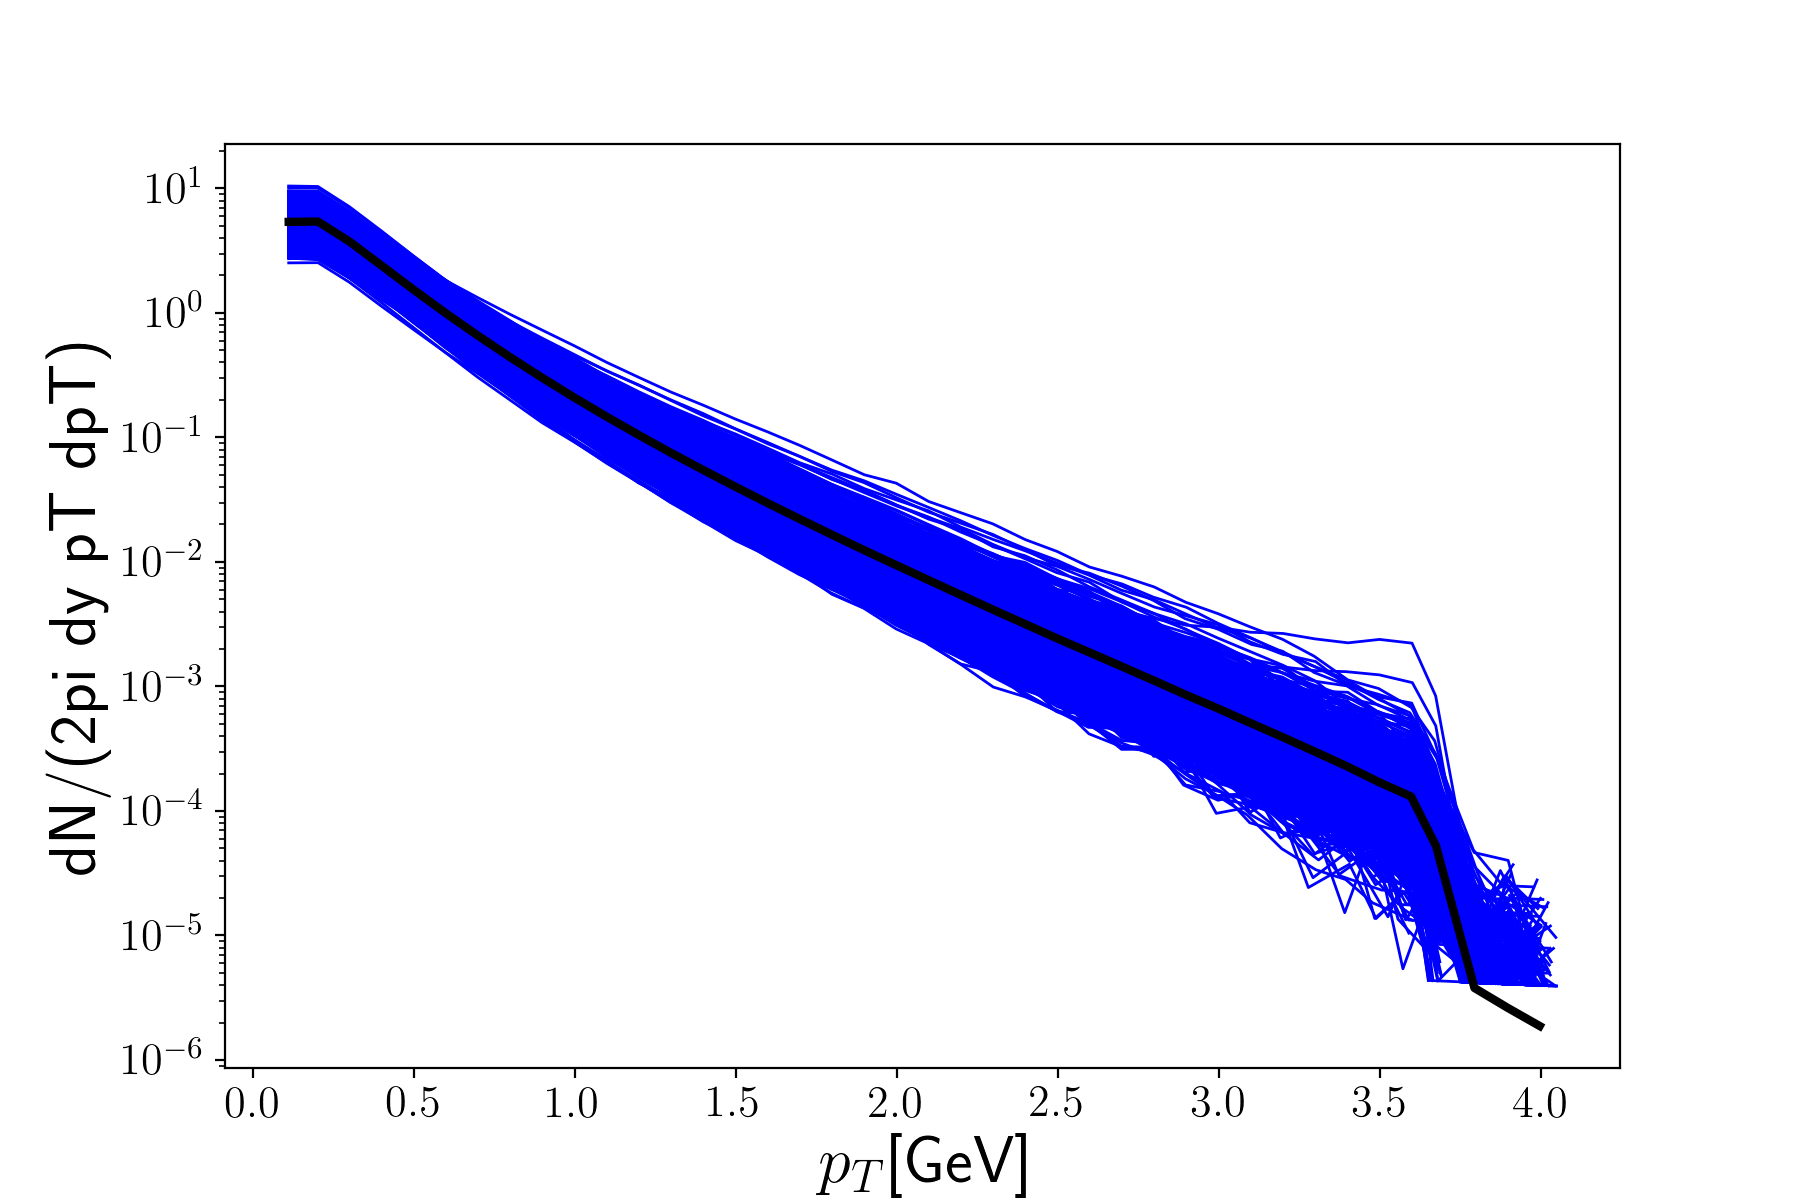

0.5615745840664016 0.5615745840664015
<dN_ch/deta> = 4.510786309230769 +/- 0.035915886925672214
sqrt(Cm)/<pT>= 6.119e-02  +/-  1.464e-03
sqrt(Cm)/<pT>_fixmult= 6.017e-02  +/-  1.451e-03
sqrt(Cm_est)/<pT>_est_fixmult= 5.511e-01  +/-  2.060e-02


975

In [202]:
#Compute Cm and its estimator

#plot e-by-e pT-spectra
fig = plt.figure()
fig.set_size_inches(9,6)
plt.yscale('log')
plt.xlabel(r'$p_T$[GeV]', fontsize = 24)
plt.ylabel(r'dN/(2pi dy pT dpT)', fontsize = 24)
def f(x):
    return 2.*dN_dy_avg/pi*np.exp(-2.*((x)/mean_pT))/mean_pT**2.
def g(x):
    return 2.*dN_dy_avg/pi*np.exp(-2.*((x)/(mean_pT))**0.97)/(mean_pT)**2.

for iev in range(nev):
    plt.plot(pT_array[iev,:],dN_array[iev,:], color = 'blue', linewidth=1)
plt.plot(pT_spectra,dN_spectra, color = 'black', label=r"charged")
#plt.plot(pT_spectra,f(pT_spectra), color = 'red', label=r"charged")
#plt.plot(pT_spectra,g(pT_spectra), color = 'green', label=r"charged")
plt.savefig('/Users/schenke/projects/CYM/Derek/spectra-'+system+energy+'GeV.pdf') 
r_avg = mean(r_ev)

ecc_2_ev=array(ecc_2_ev)
r_ev=array(r_ev)
r2_ev=array(r2_ev)

##plot the correlation of r with epsilon_2
#fig01 = plt.figure()
##plt.xlim(0,3)
##plt.ylim(0,1)
#plt.xlabel(r'[r] [fm]', fontsize = 18)
#plt.ylabel(r'$\epsilon_2$', fontsize = 18)
#plt.text(1, 0.9, r'Pb+Pb 5020GeV 0-5%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(r_ev, ecc_2_ev, c="b", alpha=0.2, marker='o')
#plt.legend(fontsize=20, loc=2) 
#plt.savefig('/Users/schenke/projects/CYM/Derek/r-epsilon2-'+system+energy+'GeV.pdf') 

##compute the r <pT> correlation
#r_avg = mean(r_ev)
#r_avg_Nwgt = mean(r_ev/multEv**(1./3.))
#fig0 = plt.figure()
#fig0.set_size_inches(7,6)
##plt.xlim(0,120)
##plt.ylim(0.45,1)
#plt.xlabel(r'${\rm est}/<{\rm est}>$', fontsize = 18)
#plt.ylabel(r'$[p_T]/\langle [p_T] \rangle$', fontsize = 18)
#plt.text(40, 0.475, r'Pb+Pb 5020GeV 0-5%', fontsize = 18)
#plt.tight_layout()
#plt.scatter((entropy_density_avg)/mean(entropy_density_avg),(mean_pTEv)/mean(mean_pTEv), c="g", alpha=0.2, marker='o',label='est=$<s>$')
#plt.scatter((multEv/(r_ev*r_ev)),(mean_pTEv), c="g", alpha=0.2, marker='o',label='est=$dN/d\eta ([r]^{-2})$')
#plt.scatter((multEv/(r_ev*r_ev*sqrt(1.-ecc_2_ev*ecc_2_ev))),(mean_pTEv), c="r", alpha=0.1, marker='o',
#            label='est=$dN/d\eta ([r]^{-2} (1-\epsilon_2^2)^{-1/2})$')
#plt.legend(fontsize=20, loc=2) 
#plt.savefig('/Users/schenke/projects/CYM/Derek/Estimator-meanpT-'+system+energy+'GeV.pdf') 
    
##compute the r/N^{13} <pT> correlation
#r_avg = mean(r_ev)
#fig1 = plt.figure()
#fig1.set_size_inches(7,6)
#plt.xlim(-0.3,0.3)
#plt.ylim(-0.1,0.1)
#plt.xlabel(r'$(\Delta r/N^{1/3})/\langle r/N^{1/3}\rangle$', fontsize = 18)
#plt.ylabel(r'$\Delta p_T/\langle p_T \rangle$', fontsize = 18)
#plt.text(2.2, 0.55, r'Au+Au 200GeV 30-40%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(((r_ev/multEv**(1./3.)-r_avg_Nwgt))/(r_avg_Nwgt),(mean_pTEv-mean_pT)/mean_pT, c="b", alpha=0.5, marker='o')
#plt.savefig('/Users/schenke/projects/CYM/Derek/Deltar-DeltapT-scaled-AuAu-30-40pct-200GeV.pdf') 
  
    
#compute the (dr-<drdN>/<dN^2> dN) <pT> correlation
deltaN_05 = multEv_05-mean(multEv_05)
deltar = r_ev-r_avg
#deltardeltaN_avg = mean(deltar*deltaN_05)
deltaNdeltaN_avg = mean(deltaN_05*deltaN_05)
#dr_fixmult = deltar - deltardeltaN_avg/deltaNdeltaN_avg*deltaN_05
#dr_fixmult_avg = np.sqrt(mean(dr_fixmult**2.))
        
deltaP = mean_pTEv_0152-mean(mean_pTEv_0152)
deltaPdeltaN_avg = mean(deltaP*deltaN_05)
dP_fixmult = deltaP - deltaPdeltaN_avg/deltaNdeltaN_avg*deltaN_05
dP_fixmult_avg = sqrt(mean(dP_fixmult**2.))
    
#fit = np.polyfit(dr_fixmult/dr_fixmult_avg, dP_fixmult/dP_fixmult_avg, 1)
#fig1 = plt.figure()
#fig1.set_size_inches(7,6)
#plt.xlim(-0.3,0.3)
#plt.ylim(-0.2,0.2)
#plt.xlabel(r'$(\delta r -  \delta N \langle \delta r \delta N\rangle/\langle \delta N^2\rangle)/\langle r \rangle$', fontsize = 18)
#plt.ylabel(r'$(\delta P -  \delta N \langle \delta P \delta N\rangle/\langle \delta N^2\rangle)/\langle P \rangle$ ', fontsize = 18)
#plt.text(-0.08, 0.15, r'Pb+Pb 5020GeV 0-5%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(dr_fixmult/dr_fixmult_avg,dP_fixmult/dP_fixmult_avg, c="b", alpha=0.5, marker='o')
#plt.plot(dr_fixmult/dr_fixmult_avg,fit[0]*(dr_fixmult/dr_fixmult_avg)+1, c="r")
#plt.savefig('/Users/schenke/projects/CYM/Derek/Deltar-DeltapT-fixmult-'+system+energy+'GeV.pdf') 
#print(fit[0])

##plot e2 v2 correlation
#fig1 = plt.figure()
#fig1.set_size_inches(7,6)
#plt.xlim(0,1)
#plt.ylim(0,0.15)
#plt.xlabel(r'$\epsilon_2$', fontsize = 18)
#plt.ylabel(r'$v_2$', fontsize = 18)
#plt.text(40, 0.475, r'Au+Au 200GeV 30-40%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(ecc_2_ev, v2, c="b", alpha=0.2, marker='o',label='')

#plt.legend(fontsize=20, loc=2)

##compute the (dr^2-<dr^2dN>/<dN^2> dN) <pT> correlation
#r2_avg = mean(r2_ev)
#deltar2 = r2_ev-r2_avg
#deltar2deltaN_avg = mean(deltar2*deltaN)
#dr2_fixmult = deltar2 - deltar2deltaN_avg/deltaNdeltaN_avg*deltaN
#dr2_fixmult_avg = mean(dr2_fixmult)
    
## fit slope over finite range      
#indices = (dr2_fixmult/r2_avg).argsort()
#sorted_x = (dr2_fixmult/r2_avg)[indices]
#sorted_y = (dP_fixmult/P)[indices]
#fit = np.polyfit(sorted_x[10:-20], sorted_y[10:-20], 1)

#fig1 = plt.figure()
#fig1.set_size_inches(7,6)
#plt.xlim(-0.8,0.8)
#plt.ylim(-0.2,0.2)
#plt.xlabel(r'$(\delta r^2 -  \delta N \langle \delta r^2 \delta N\rangle/\langle \delta N^2\rangle)/\langle r^2 \rangle$', fontsize = 18)
#plt.ylabel(r'$(\delta P -  \delta N \langle \delta P \delta N\rangle/\langle \delta N^2\rangle)/\langle P \rangle$ ', fontsize = 18)
#plt.text(-0.1, 0.15, r'Pb+Pb 5020GeV 0-5%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(dr2_fixmult/r2_avg,dP_fixmult/P, c="b", alpha=0.5, marker='o')
#plt.plot(dr2_fixmult/r2_avg,fit[0]*(dr2_fixmult/r2_avg)+1, c="r")
#plt.savefig('/Users/schenke/projects/CYM/Derek/Deltar2-DeltapT-fixmult-'+system+energy+'GeV.pdf') 
#print(fit[0])

#use better estimator of area

#r2_avg = mean((r2_ev*sqrt(1.-ecc_2_ev*ecc_2_ev)))
#deltar2 = (r2_ev*sqrt(1.-ecc_2_ev*ecc_2_ev))#-r2_avg
#deltar2deltaN_avg = mean(deltar2*deltaN_05)
#dr2_fixmult = deltar2 - deltar2deltaN_avg/deltaNdeltaN_avg*deltaN_05
#dr2_fixmult_avg = mean(dr2_fixmult)
    
## fit slope over finite range      
#indices = (dr2_fixmult/r2_avg).argsort()
#sorted_x = (dr2_fixmult/r2_avg)[indices]
#sorted_y = (dP_fixmult/P)[indices]
#fit = np.polyfit(sorted_x[10:-20], sorted_y[10:-20], 1)

#fig1 = plt.figure()
#fig1.set_size_inches(7,6)
#plt.xlim(-0.8,0.8)
#plt.ylim(-0.2,0.2)
#plt.xlabel(r'$(\delta r^2\sqrt{1-\epsilon_2^2} -  \delta N \langle \delta r^2\sqrt{1-\epsilon_2^2} \delta N\rangle/\langle \delta N^2\rangle)/\langle r^2\sqrt{1-\epsilon_2^2} \rangle$', fontsize = 18)
#plt.ylabel(r'$(\delta P -  \delta N \langle \delta P \delta N\rangle/\langle \delta N^2\rangle)/\langle P \rangle$ ', fontsize = 18)
#plt.text(-0.1, 0.15, r'Pb+Pb 5020GeV 0-5%', fontsize = 18)
#plt.tight_layout()
#plt.scatter(dr2_fixmult/r2_avg,dP_fixmult/P, c="b", alpha=0.5, marker='o')
#plt.plot(dr2_fixmult/r2_avg,fit[0]*(dr2_fixmult/r2_avg)+1, c="r")
#plt.savefig('/Users/schenke/projects/CYM/Derek/Deltar2ecc-DeltapT-fixmult-'+system+energy+'GeV.pdf')    
#print(fit[0])

#compute C_m/<pT>
mean_pTEvdeltaN_avg = mean(mean_pTEv_0152*deltaN_05)
mean_pTEv_fixmult = mean_pTEv_0152 - mean_pTEvdeltaN_avg/deltaNdeltaN_avg*deltaN_05

sigmaMpTSq = mean(mean_pTEv_0152**2.)-mean(mean_pTEv_0152)**2.
MpT = mean(mean_pTEv_0152)

sigmaMpTSq_fixmult = mean(mean_pTEv_fixmult**2.)-mean(mean_pTEv_fixmult)**2.
MpT_fixmult = mean(mean_pTEv_fixmult)

print(MpT_fixmult, MpT)

CmOverMpT = sqrt(sigmaMpTSq)/MpT
CmOverMpT_fixmult = sqrt(sigmaMpTSq_fixmult)/MpT_fixmult 

#compute jackknife error:
summe=0
for i in range(nev):
    temp_i = np.delete(mean_pTEv_0152,i)
    mean_i = mean(temp_i)
    summe += (sqrt(mean(temp_i**2.)-mean_i**2.)/mean_i-sqrt(sigmaMpTSq)/MpT)**2.
summe *= (float(nev)-1)/float(nev)
error = sqrt(summe)

summe_fixmult=0
for i in range(nev):
    temp_i = np.delete(mean_pTEv_fixmult,i)
    mean_i = mean(temp_i)
    summe_fixmult += (sqrt(mean(temp_i**2.)-mean_i**2.)/mean_i-sqrt(sigmaMpTSq_fixmult)/MpT_fixmult)**2.
summe_fixmult *= (float(nev)-1)/float(nev)
error_fixmult = sqrt(summe_fixmult)

#delta_e22 = ecc_2_ev*ecc_2_ev-mean(ecc_2_ev*ecc_2_ev)
#deltae22deltaN_avg = mean(delta_e22*deltaN)
#de22_fixmult = delta_e22 - deltae22deltaN_avg/deltaNdeltaN_avg*deltaN
#de22_fixmult_avg = sqrt(mean(de22_fixmult**2.))

deltaEst = entropy/(r2_ev*sqrt(1.-ecc_2_ev**2.)) #array(entropy_density_avg)
deltaEstdeltaN_avg = mean(deltaEst*deltaN_05)

dEst_fixmult = deltaEst - deltaEstdeltaN_avg/deltaNdeltaN_avg*deltaN_05
dEst_fixmult_avg = sqrt(mean(dEst_fixmult**2.))

#deltaEst2 = ecc_2_ev*ecc_2_ev#-mean(ecc_2_ev*ecc_2_ev)
#deltaEst2deltaN_avg = mean(deltaEst2*deltaN_05)

#dEst3_fixmult = dEst_fixmult - de22_fixmult*mean(dEst_fixmult*de22_fixmult)/mean(de22_fixmult**2.) 
#dEst3_fixmult_avg = sqrt(mean(dEst3_fixmult**2.))
#dEst2_fixmult = deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN_05 -dEst3_fixmult*mean((deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN_05)*dEst3_fixmult)/mean(dEst3_fixmult**2.) 
#dEst2_fixmult_avg = sqrt(mean(dEst2_fixmult**2.))

#RdEst2dP = mean(dEst2_fixmult*MpT_fixmult)/dEst2_fixmult_avg/mean(MpT_fixmult)
#RdEst3dP = mean(dEst3_fixmult*MpT_fixmult)/dEst3_fixmult_avg/mean(MpT_fixmult)

#dEst_total_fixmult = (RdEst3dP*dEst3_fixmult/dEst3_fixmult_avg) + (RdEst2dP*dEst2_fixmult/dEst2_fixmult_avg)
#dEst_total_fixmult_avg = sqrt(mean(dEst_total_fixmult**2.))

#compute sqrt(C_m)/<pT> estimator
sigmaMpTSq_est_fixmult = mean(dEst_fixmult**2.)-mean(dEst_fixmult)**2.
MpT_est_fixmult = mean(dEst_fixmult)

CmOverMpT_est_fixmult = sqrt(sigmaMpTSq_est_fixmult)/MpT_est_fixmult

summe_est_fixmult=0
for i in range(nev):
    temp_i = np.delete(dEst_fixmult,i)
    mean_i = mean(temp_i)
    summe_est_fixmult += (sqrt(mean(temp_i**2.)-mean_i**2.)/mean_i-sqrt(sigmaMpTSq_est_fixmult)/MpT_est_fixmult)**2.
summe_est_fixmult *= (float(nev)-1)/float(nev)
error_est_fixmult = sqrt(summe_est_fixmult)

print("<dN_ch/deta> =",dN_dy_avg,"+/-",dN_dy_avg_err)
print("sqrt(Cm)/<pT>=","%.3e"%CmOverMpT," +/- ","%.3e"%error)
print("sqrt(Cm)/<pT>_fixmult=","%.3e"%CmOverMpT_fixmult," +/- ","%.3e"%error_fixmult)
print("sqrt(Cm_est)/<pT>_est_fixmult=","%.3e"%CmOverMpT_est_fixmult," +/- ","%.3e"%error_est_fixmult)

size(deltaEst)

R(e2-v2)= 0.8107446214413521
R(Est-P)= 1.0
R(de2dv2)_N= 0.04015990316828613
R(dEst2-dv2)= 0.03987988967012898
R(S^(-1)P)= 0.8537470232366076
R(dEst-dP)= 0.8537470232366076
R(dEst3-dP)= 0.8733095992331015
R(dEst2-dP)= -0.026174914203814355
R(dEst-dEst2)= -0.17178751267571551
R(dEst-dEst2 fm)= -0.23943842676503518
R(dEst3-dEst2 fm)= 1.19799237388594e-17
Q_dP-dEst= 0.8638018670040096
Q_dP-dEstTotal= 0.8703995710816618
dEst_total_fixmult_avg= 0.8737017696252293
R(dEst_total-dP)= 0.8737017696252295


<IPython.core.display.Javascript object>


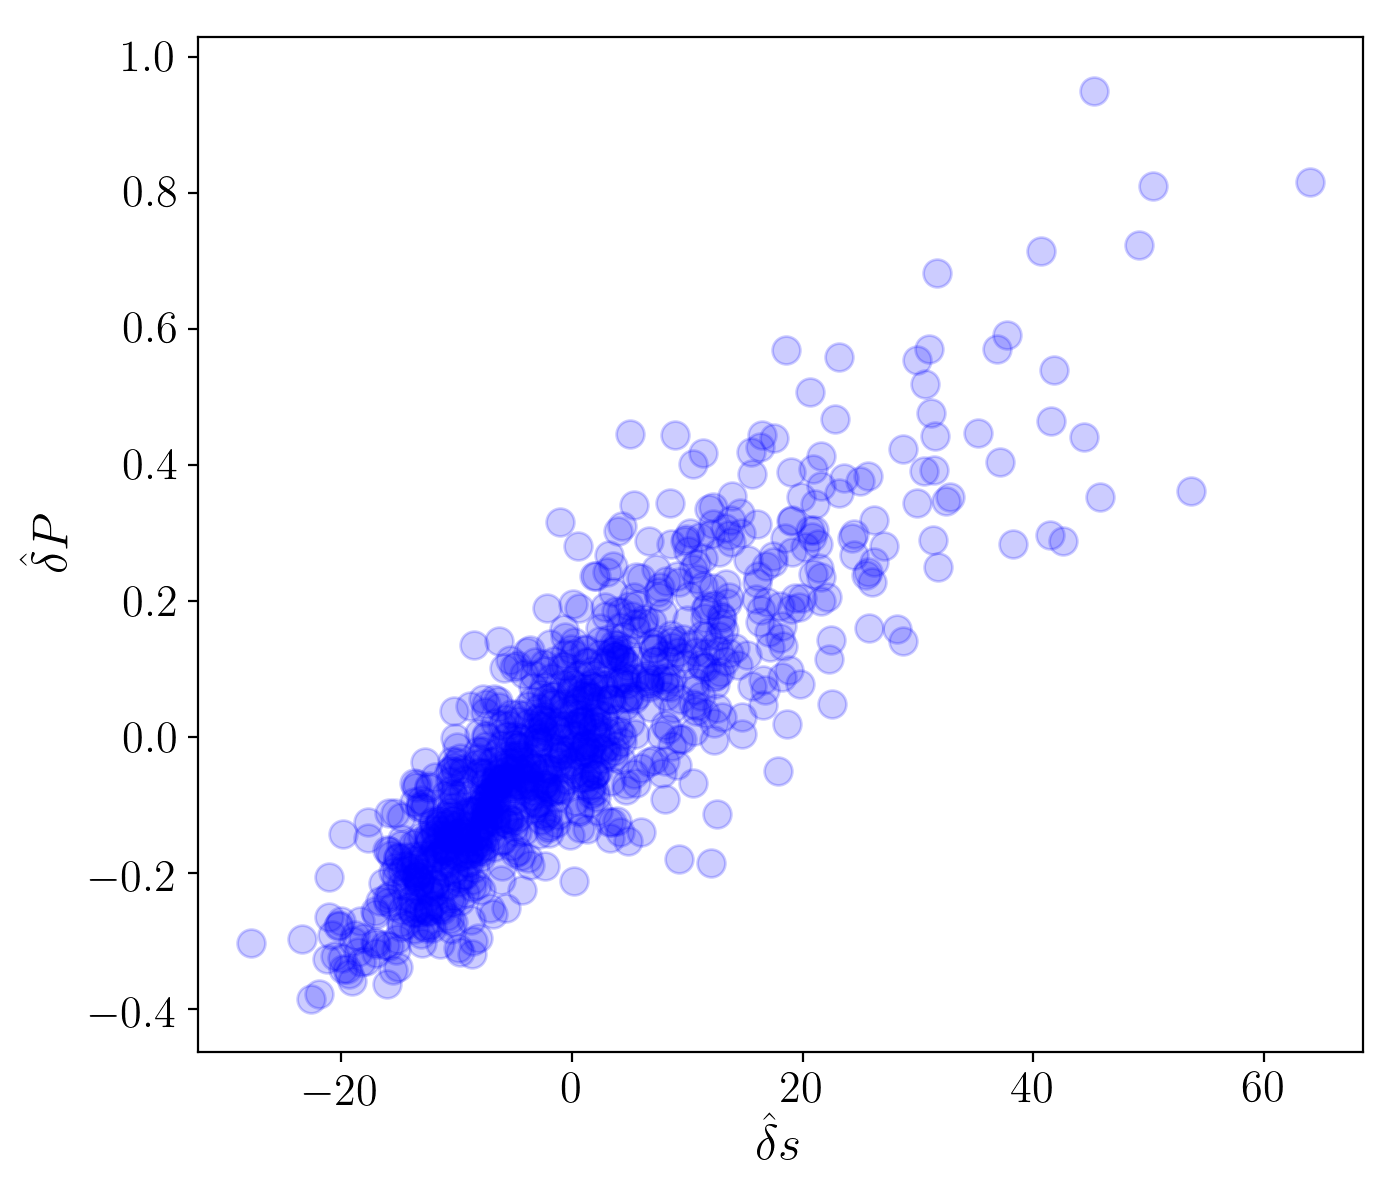

<IPython.core.display.Javascript object>


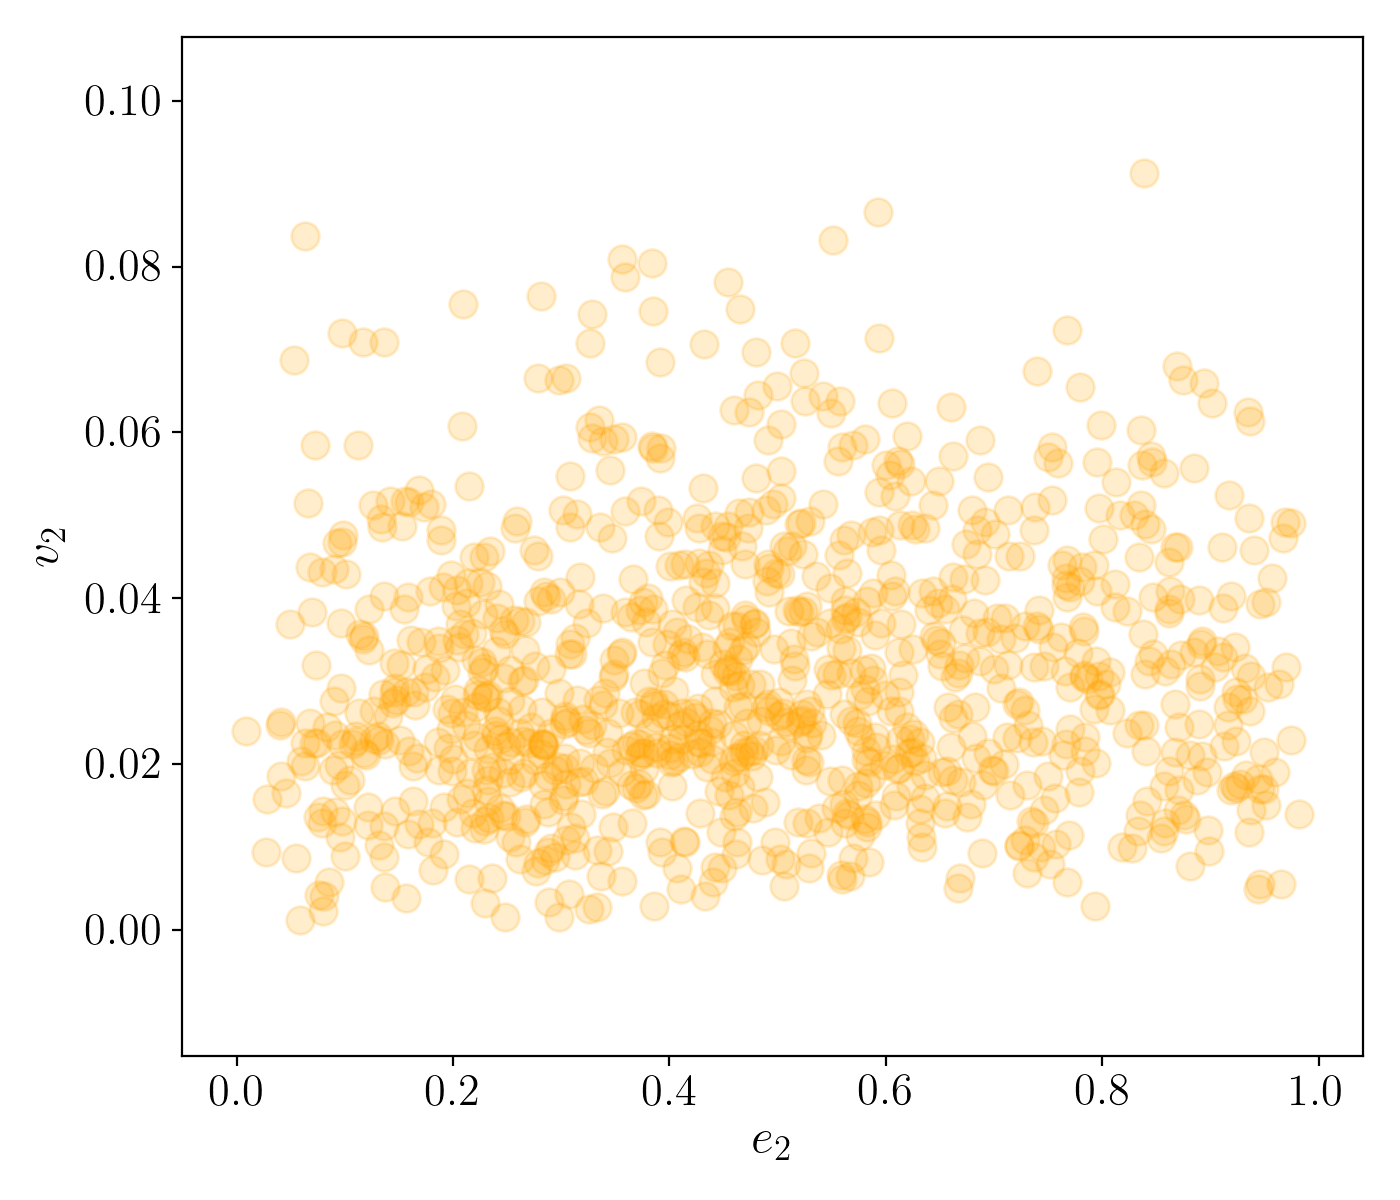

size of de22_fixmult_total:  975
size of dv22_fixmult:  975
R(de2_total-dv2)_N= 0.04297640275831252


<IPython.core.display.Javascript object>


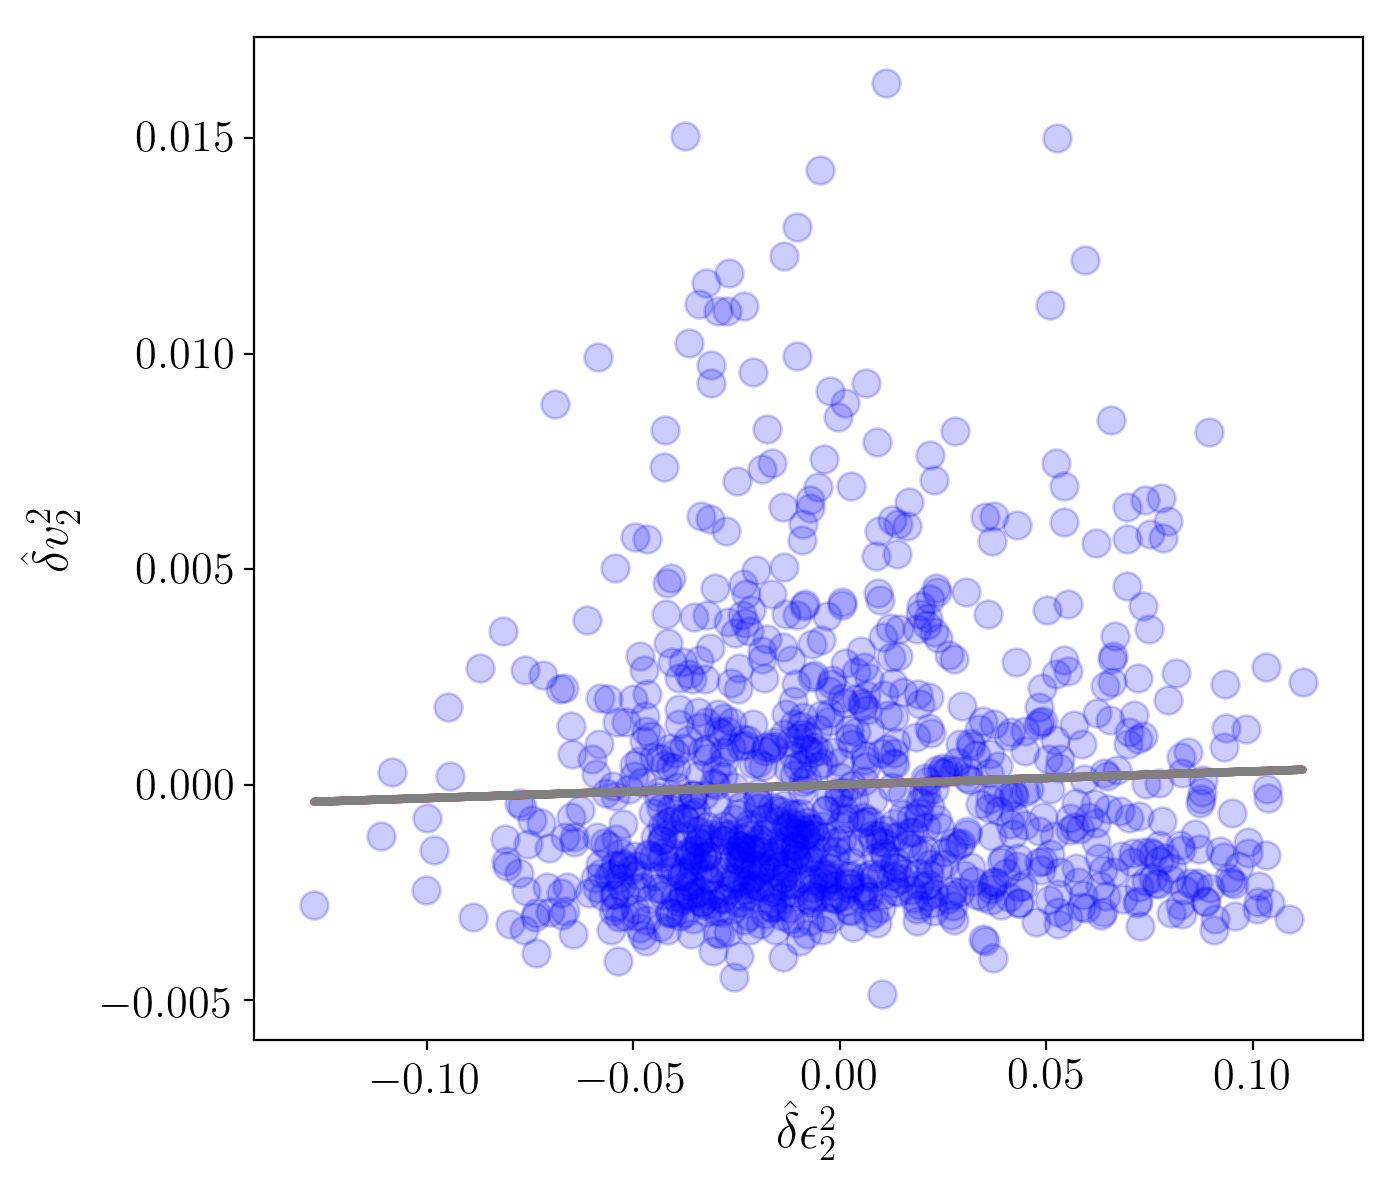

0.003108160664517016


<IPython.core.display.Javascript object>


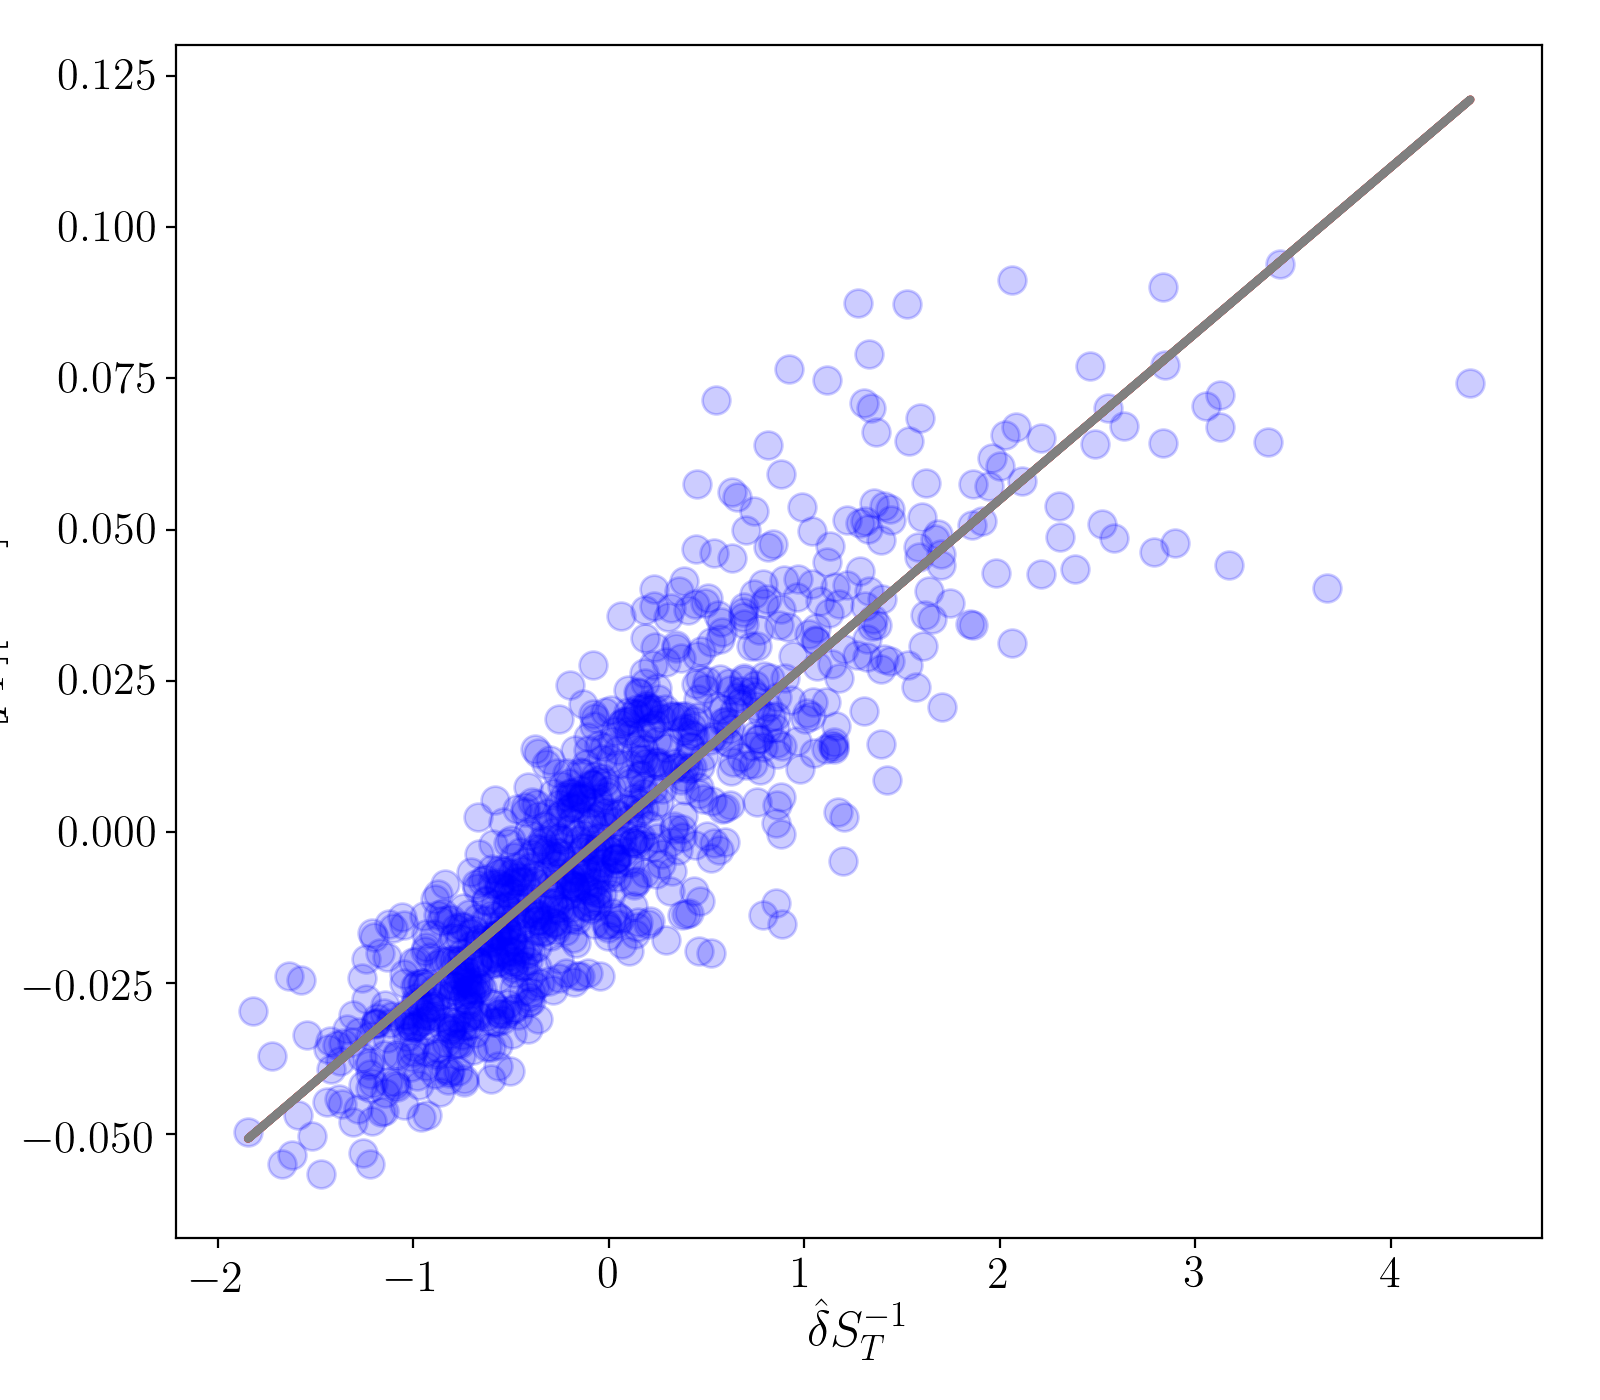

0.02747293321664176


<IPython.core.display.Javascript object>


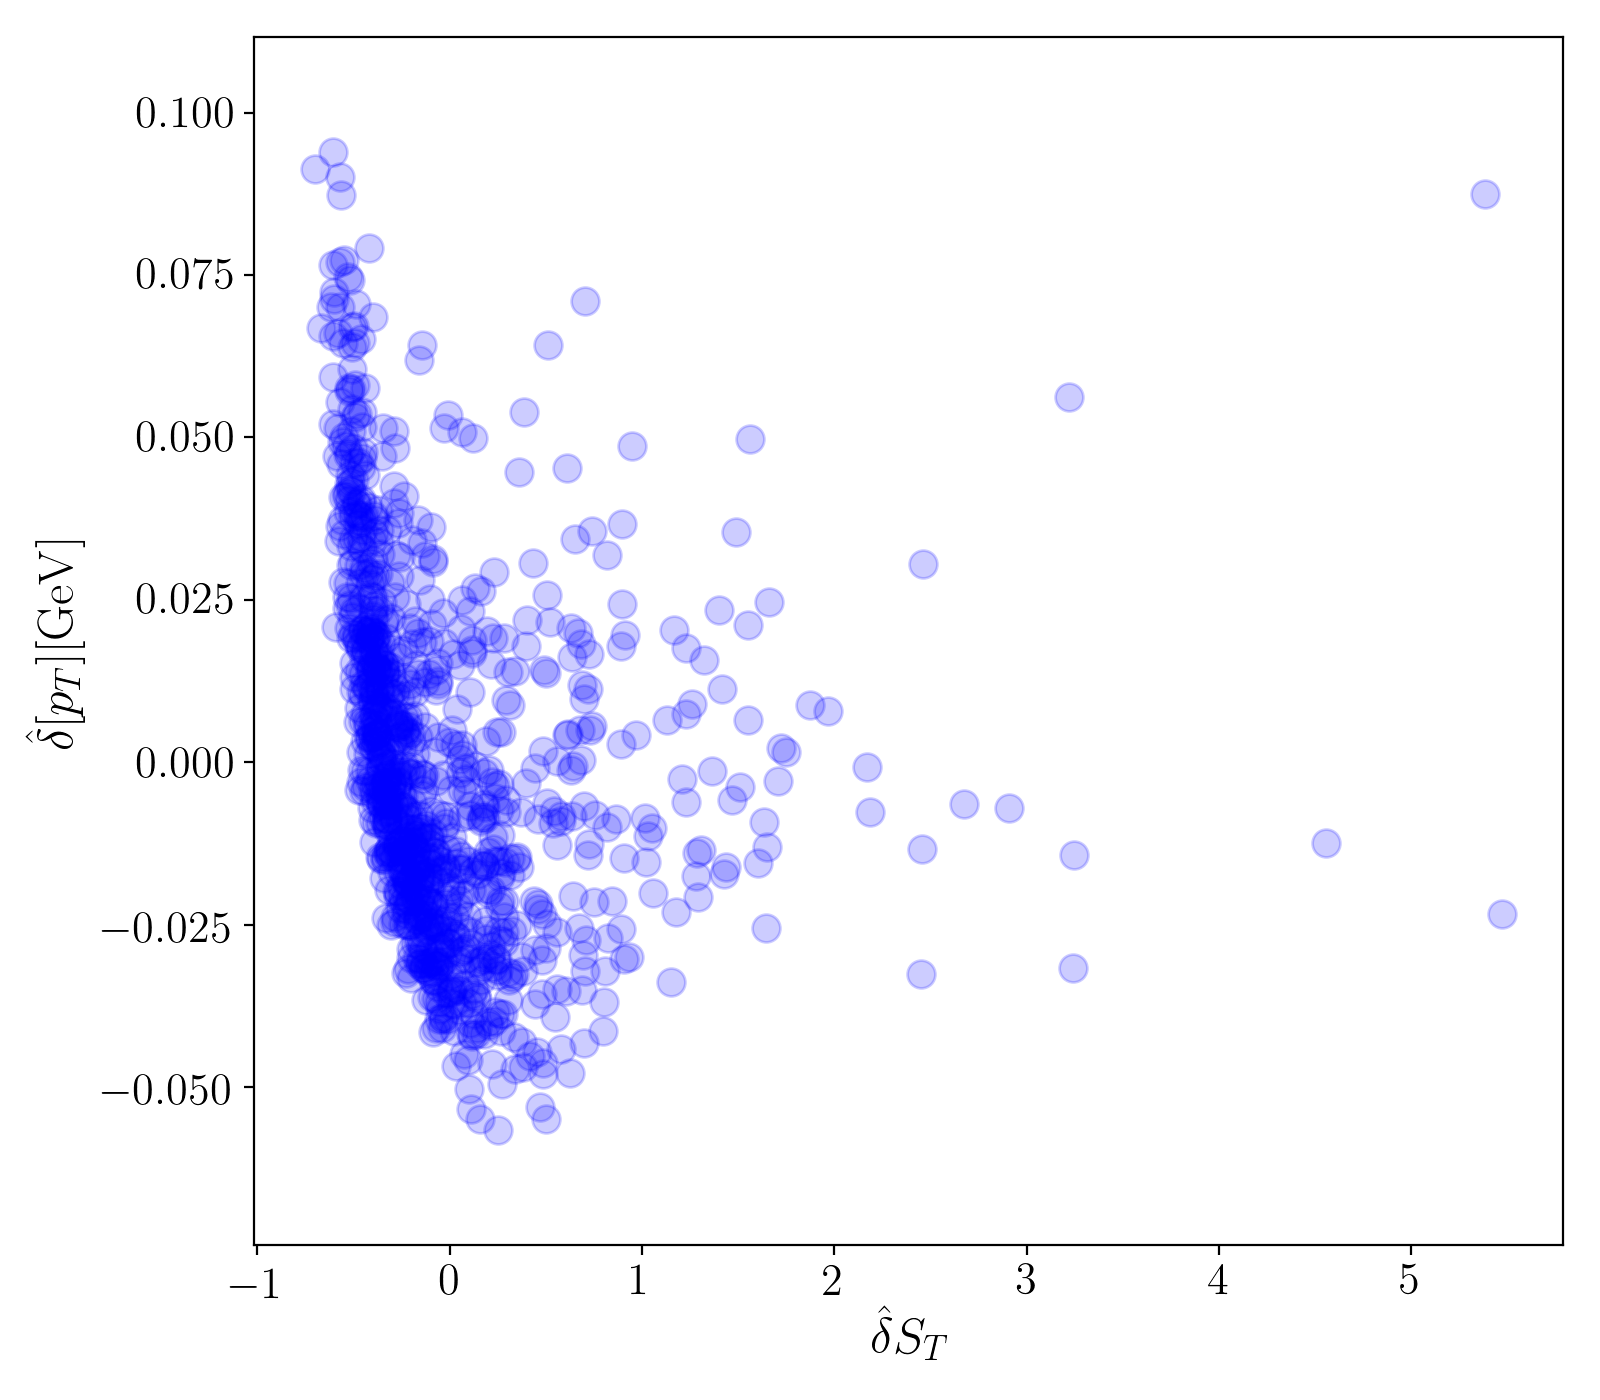

<IPython.core.display.Javascript object>


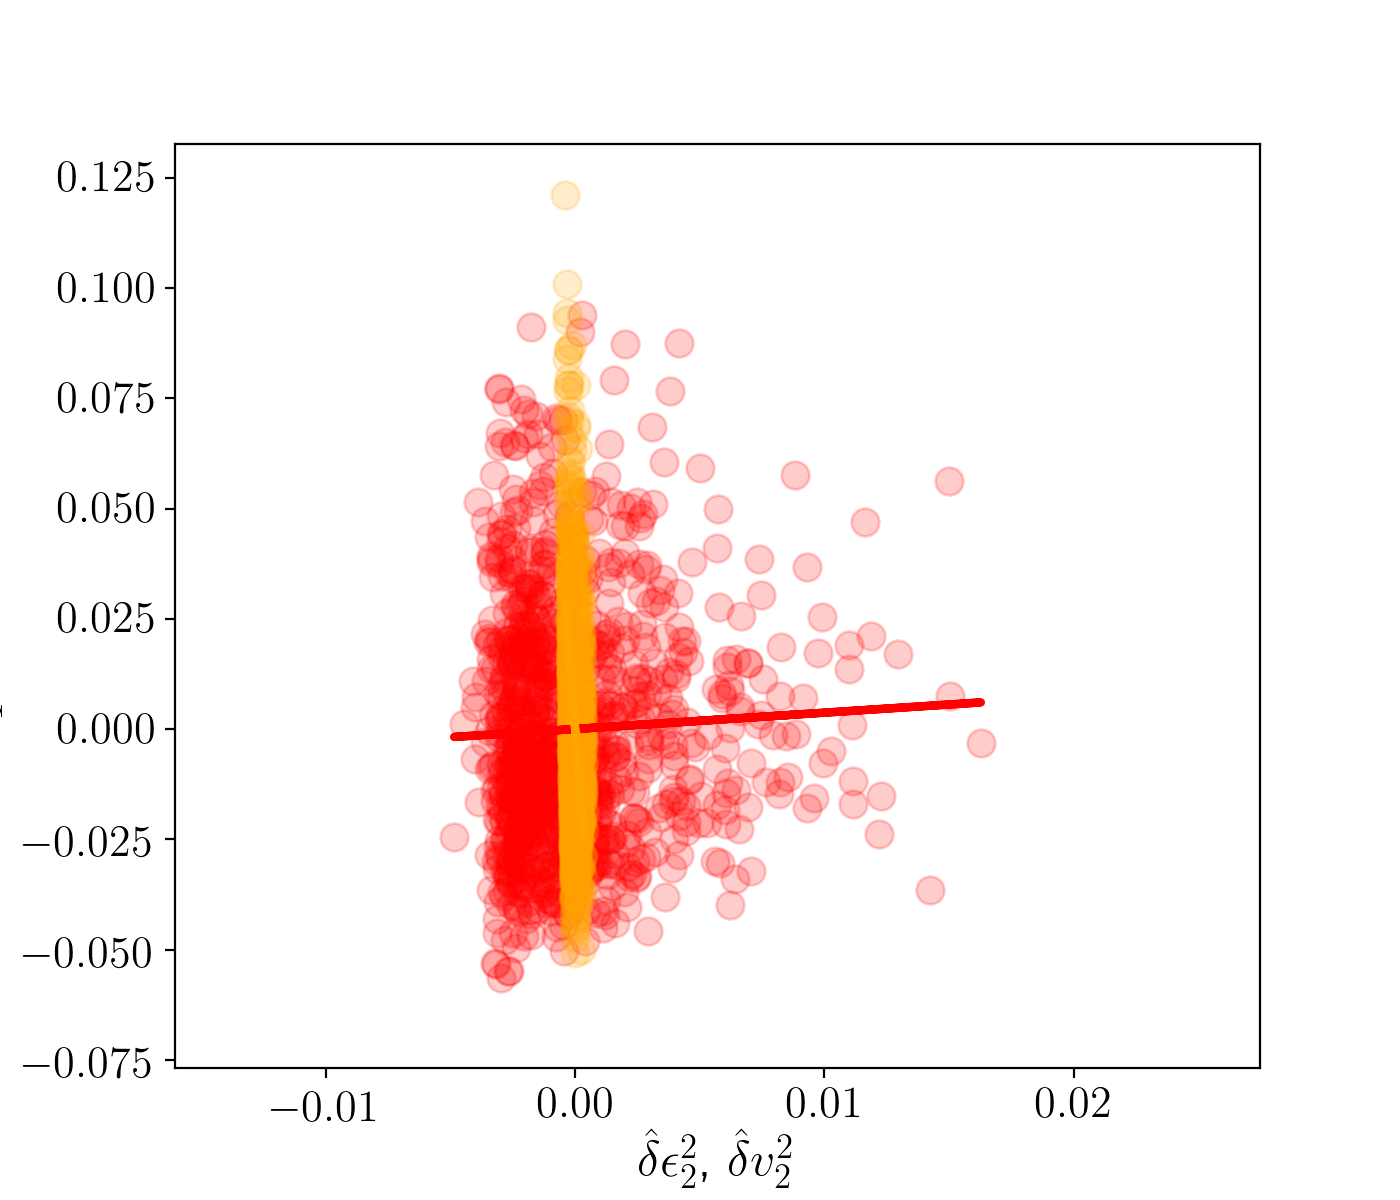

<dN_ch/deta> = 4.510786309230769 +/- 0.035915886925672214
c_k(0.2-2)= 1.128e-03  +/-  5.609e-05
c_k(0.5-2)= 7.548e-04  +/-  3.545e-05
c_k(1-2)= 1.884e-04  +/-  8.494e-06
Var(v_2\{2\}^2)(0.2-2)= 1.450e-06  +/-  1.212e-07
Var(v_2\{2\}^2)(0.5-2)= 9.661e-06  +/-  7.481e-07
Var(v_2\{2\}^2)(1-2)= 5.246e-05  +/-  4.204e-06
Cov(v_2\{2\}^2),[pT])(0.2-2)= 5.569e-06  +/-  1.329e-06
Cov(v_2\{2\}^2),[pT])(0.5-2)= 3.581e-06  +/-  2.558e-06
Cov(v_2\{2\}^2),[pT])(1-2)= -5.602e-06  +/-  3.004e-06
Correlator R2(0.2-2GeV)= 1.376e-01  +/-  3.284e-02
Correlator R2(0.5-2GeV)= 4.193e-02  +/-  2.996e-02
Correlator R2(1-2GeV)= -5.635e-02  +/-  3.022e-02
Correlator R3(0.2-2GeV)= 2.843e-01  +/-  3.679e-02
Correlator R3(0.5-2GeV)= 1.752e-01  +/-  3.104e-02
Correlator R3(1-2GeV)= 1.924e-03  +/-  2.733e-02
Estimator correlator R_est ***entropy per area, see above***= -4.003e-01  +/-  4.199e-02
Simple estimator correlator R_est_sim= -2.395e-01  +/-  3.125e-02
Entropy per area estimator correlator R_est= -6.126e-01  

In [203]:
#v2^2 [pT] correlations
#note big difference in Pearson coefficients when using 0-5GeV vs. 0.5-5 GeV range - do Pearson coefficient in next 

deltaN_05 = multEv_05-mean(multEv_05)
deltaNdeltaN_avg = mean(deltaN_05*deltaN_05)

area = array(area)
uT = array(uT)
ep = array(ep)
ecc_3_ev = array(ecc_3_ev)
entropy = array(entropy)
entropy_density_avg = array(entropy_density_avg)
entropy_density_rms = array(entropy_density_rms)

#0.2-2 GeV cut:
delta_v22_022 = v2_cut_02_2*v2_cut_02_2-mean(v2_cut_02_2*v2_cut_02_2)
deltav22deltaN_022_avg = mean(delta_v22_022*deltaN_05)
dv22_022_fixmult = delta_v22_022 - deltav22deltaN_022_avg/deltaNdeltaN_avg*deltaN_05
dv22_022_fixmult_avg = sqrt(mean(dv22_022_fixmult**2.))

delta_v32_022 = v3_cut_02_2*v3_cut_02_2-mean(v3_cut_02_2*v3_cut_02_2)
deltav32deltaN_022_avg = mean(delta_v32_022*deltaN_05)
dv32_022_fixmult = delta_v32_022 - deltav32deltaN_022_avg/deltaNdeltaN_avg*deltaN_05
dv32_022_fixmult_avg = sqrt(mean(dv32_022_fixmult**2.))

deltaP_022 = P_ev_022-mean(P_ev_022) # cut should be 0.2-2GeV
deltaP_022deltaN_avg = mean(deltaP_022*deltaN_05)
deltaP_022_fixmult = deltaP_022 - deltaP_022deltaN_avg/deltaNdeltaN_avg*deltaN_05

deltapT_022 = mean_pTEv_022 - mean(mean_pTEv_022)
deltapT_022deltaN_avg = mean(deltapT_022*deltaN_05)
dpT_022_fixmult = deltapT_022 - deltapT_022deltaN_avg/deltaNdeltaN_avg*deltaN_05
dpT_022_fixmult_avg = sqrt(mean(dpT_022_fixmult**2.))

cov_v2sq_pT_022 = dv22_022_fixmult*dpT_022_fixmult/dpT_022_fixmult_avg/dv22_022_fixmult_avg  # dP_fixmult_avg is rms
cov_v3sq_pT_022 = dv32_022_fixmult*dpT_022_fixmult/dpT_022_fixmult_avg/dv32_022_fixmult_avg  # dP_fixmult_avg is rms

#0.5-2 GeV cut:
delta_v22 = v2_cut_05_2*v2_cut_05_2-mean(v2_cut_05_2*v2_cut_05_2)
deltav22deltaN_avg = mean(delta_v22*deltaN_05)
dv22_fixmult = delta_v22 - deltav22deltaN_avg/deltaNdeltaN_avg*deltaN_05
dv22_fixmult_avg = sqrt(mean(dv22_fixmult**2.))

delta_v32 = v3_cut_05_2*v3_cut_05_2-mean(v3_cut_05_2*v3_cut_05_2)
deltav32deltaN_avg = mean(delta_v32*deltaN_05)
dv32_fixmult = delta_v32 - deltav32deltaN_avg/deltaNdeltaN_avg*deltaN_05
dv32_fixmult_avg = sqrt(mean(dv32_fixmult**2.))

deltaP_052 = P_ev_052-mean(P_ev_052) # cut should be 0.5-2GeV
deltaP_052deltaN_avg = mean(deltaP_052*deltaN_05)
deltaP_052_fixmult = deltaP_052 - deltaP_052deltaN_avg/deltaNdeltaN_avg*deltaN_05

deltapT_052 = mean_pTEv_052 - mean(mean_pTEv_052)
deltapT_052deltaN_avg = mean(deltapT_052*deltaN_05)
dpT_052_fixmult = deltapT_052 - deltapT_052deltaN_avg/deltaNdeltaN_avg*deltaN_05
dpT_052_fixmult_avg = sqrt(mean(dpT_052_fixmult**2.))

cov_v2sq_pT = dv22_fixmult*dpT_052_fixmult/dpT_052_fixmult_avg/dv22_fixmult_avg  # dP_fixmult_avg is rms
cov_v3sq_pT = dv32_fixmult*dpT_052_fixmult/dpT_052_fixmult_avg/dv32_fixmult_avg  # dP_fixmult_avg is rms

# 1-2GeV cut:
delta_v22_12 = v2_cut_1_2*v2_cut_1_2-mean(v2_cut_1_2*v2_cut_1_2)
deltav22_12deltaN_avg = mean(delta_v22_12*deltaN_05)
dv22_12_fixmult = delta_v22_12 - deltav22_12deltaN_avg/deltaNdeltaN_avg*deltaN_05
dv22_12_fixmult_avg = sqrt(mean(dv22_12_fixmult**2.))

delta_v32_12 = v3_cut_1_2*v3_cut_1_2-mean(v3_cut_1_2*v3_cut_1_2)
deltav32_12deltaN_avg = mean(delta_v32_12*deltaN_05)
dv32_12_fixmult = delta_v32_12 - deltav32_12deltaN_avg/deltaNdeltaN_avg*deltaN_05
dv32_12_fixmult_avg = sqrt(mean(dv32_12_fixmult**2.))

deltapT_12 = mean_pTEv_12 - mean(mean_pTEv_12)
deltapT_12deltaN_avg = mean(deltapT_12*deltaN_05)
dpT_12_fixmult = deltapT_12 - deltapT_12deltaN_avg/deltaNdeltaN_avg*deltaN_05
dpT_12_fixmult_avg = sqrt(mean(dpT_12_fixmult**2.))

cov_v2sq_pT_12 = dv22_12_fixmult*dpT_12_fixmult/dpT_12_fixmult_avg/dv22_12_fixmult_avg  # dP_fixmult_avg is rms
cov_v3sq_pT_12 = dv32_12_fixmult*dpT_12_fixmult/dpT_12_fixmult_avg/dv32_12_fixmult_avg  # dP_fixmult_avg is rms

#initial momentum anisotropy
delta_ep2 = ep*ep-mean(ep*ep)
deltaep2deltaN_avg = mean(delta_ep2*deltaN_05)
dep2_fixmult = delta_ep2 - deltaep2deltaN_avg/deltaNdeltaN_avg*deltaN_05
dep2_fixmult_avg = sqrt(mean(dep2_fixmult**2.))

delta_e22 = ecc_2_ev*ecc_2_ev-mean(ecc_2_ev*ecc_2_ev)
deltae22deltaN_avg = mean(delta_e22*deltaN_05)
de22_fixmult = delta_e22 - deltae22deltaN_avg/deltaNdeltaN_avg*deltaN_05
de22_fixmult_avg = sqrt(mean(de22_fixmult**2.))

delta_e32 = ecc_3_ev*ecc_3_ev-mean(ecc_3_ev*ecc_3_ev)
deltae32deltaN_avg = mean(delta_e32*deltaN_05)
de32_fixmult = delta_e32 - deltae32deltaN_avg/deltaNdeltaN_avg*deltaN_05
de32_fixmult_avg = sqrt(mean(de32_fixmult**2.))

deltaEst = entropy_density_avg - mean(entropy_density_avg)
deltaEstdeltaN_avg = mean(deltaEst*deltaN_05)
dEst_fixmult = deltaEst - deltaEstdeltaN_avg/deltaNdeltaN_avg*deltaN_05
dEst_fixmult_avg = sqrt(mean(dEst_fixmult**2.))

deltaEst_sPerArea2Ecc = entropy/(r2_ev*sqrt(1.-ecc_2_ev**2.)) - mean(entropy/(r2_ev*sqrt(1.-ecc_2_ev**2.)))
deltaEst_sPerArea2EccdeltaN_avg = mean(deltaEst_sPerArea2Ecc*deltaN_05)
dEst_sPerArea2Ecc_fixmult = deltaEst_sPerArea2Ecc - deltaEst_sPerArea2EccdeltaN_avg/deltaNdeltaN_avg*deltaN_05
dEst_sPerArea2Ecc_fixmult_avg = sqrt(mean(dEst_sPerArea2Ecc_fixmult**2.))

deltaArea = (r2_ev*sqrt(1.-ecc_2_ev**2.)) - mean((r2_ev*sqrt(1.-ecc_2_ev**2.)))
deltaAreadeltaN_avg = mean(deltaArea*deltaN_05)
delta_Area_fixmult = deltaArea - deltaAreadeltaN_avg/deltaNdeltaN_avg*deltaN_05

#*****
#dEst_fixmult = dEst_sPerArea2Ecc_fixmult
#dEst_fixmult_avg = dEst_sPerArea2Ecc_fixmult_avg
#*****


deltaEst2 = ecc_2_ev*ecc_2_ev-mean(ecc_2_ev*ecc_2_ev)
deltaEst2deltaN_avg = mean(deltaEst2*deltaN_05)

#dEst3 is dEst's piece that is orthogonal to de22
dEst3_fixmult = dEst_fixmult - de22_fixmult*mean(dEst_fixmult*de22_fixmult)/mean(de22_fixmult**2.) 
dEst3_fixmult_avg = sqrt(mean(dEst3_fixmult**2.))

#dEst2 is de22's piece that is orthogonal to dEst3
dEst2_fixmult = deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN_055 -dEst3_fixmult*mean((deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN_055)*dEst3_fixmult)/mean(dEst3_fixmult**2.) 
dEst2_fixmult_avg = sqrt(mean(dEst2_fixmult**2.))




REstP = mean(entropy_density_avg*mean_pT_052)/mean(entropy_density_avg)/mean_pT_052
Re2v2 = mean(ecc_2_ev*v2_cut_05_2)/sqrt(mean(v2_cut_05_2**2.))/sqrt(mean(ecc_2_ev**2.))
Re2e2v2v2 = mean(ecc_2_ev*ecc_2_ev*v2_cut_05_2*v2_cut_05_2)/mean(v2_cut_05_2**2.)/mean(ecc_2_ev**2.)
Rde2dv2 = mean(delta_e22*delta_v22)/sqrt(mean(delta_e22**2))/sqrt(mean(delta_v22**2))
Rde2dv2fm = mean(de22_fixmult*dv22_fixmult)/dv22_fixmult_avg/de22_fixmult_avg
RSP = mean(dEst_fixmult*dpT_052_fixmult)/dEst_fixmult_avg/dpT_052_fixmult_avg
RdEstdP = mean(dEst_fixmult*dpT_052_fixmult)/dEst_fixmult_avg/dpT_052_fixmult_avg
RdEst2dP = mean(dEst2_fixmult*dpT_052_fixmult)/dEst2_fixmult_avg/dpT_052_fixmult_avg
RdEstdEst2fm = mean(dEst_fixmult*dEst2_fixmult)/dEst_fixmult_avg/dEst2_fixmult_avg
RdEst3dEst2fm = mean(dEst3_fixmult*dEst2_fixmult)/dEst3_fixmult_avg/dEst2_fixmult_avg
RdEstdEst2 = mean(deltaEst*deltaEst2)/sqrt(mean(deltaEst**2.))/sqrt(mean(deltaEst2**2.))
RdEst2dP = mean(dEst2_fixmult*dpT_052_fixmult)/dEst2_fixmult_avg/dpT_052_fixmult_avg
RdEst3dP = mean(dEst3_fixmult*dpT_052_fixmult)/dEst3_fixmult_avg/dpT_052_fixmult_avg
RdEst3dv2 = mean(dEst3_fixmult*dv22_fixmult)/dv22_fixmult_avg/dEst3_fixmult_avg
RdEst2dv2 = mean(dEst2_fixmult*dv22_fixmult)/dv22_fixmult_avg/dEst2_fixmult_avg

print("R(e2-v2)=",Re2v2)
print("R(Est-P)=",REstP)
print("R(de2dv2)_N=",Rde2dv2fm)
print("R(dEst2-dv2)=",RdEst2dv2)
print("R(S^(-1)P)=",RSP)
print("R(dEst-dP)=",RdEstdP)
print("R(dEst3-dP)=",RdEst3dP)
print("R(dEst2-dP)=",RdEst2dP)
print("R(dEst-dEst2)=",RdEstdEst2)
print("R(dEst-dEst2 fm)=",RdEstdEst2fm)
print("R(dEst3-dEst2 fm)=",RdEst3dEst2fm)

##
dEst_total_fixmult = (RdEst3dP*dEst3_fixmult/dEst3_fixmult_avg) + (RdEst2dP*dEst2_fixmult/dEst2_fixmult_avg)
dEst_total_fixmult_avg = sqrt(mean(dEst_total_fixmult**2.))
##

Pearson = mean(deltaP_052_fixmult*dEst_fixmult)/sqrt(mean(dEst_fixmult**2.)*mean(deltaP_052_fixmult**2.))
print("Q_dP-dEst=",Pearson)
Pearson_total = mean(deltaP_052_fixmult*dEst_total_fixmult)/sqrt(mean(dEst_total_fixmult**2.)*mean(deltaP_052_fixmult**2.))
print("Q_dP-dEstTotal=",Pearson_total)

print("dEst_total_fixmult_avg=",dEst_total_fixmult_avg)
RdEsttotaldP = mean(dEst_total_fixmult*dpT_052_fixmult)/dpT_052_fixmult_avg/dEst_total_fixmult_avg
print("R(dEst_total-dP)=",RdEsttotaldP)

fig1 = plt.figure()
fig1.set_size_inches(7,6)
#plt.xlim(-0.15,0.2)
#plt.ylim(-10,15)
plt.xlabel(r'$\hat{\delta}s$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}P$', fontsize = 18)
plt.scatter(dEst_fixmult, deltaP_052_fixmult, c="b", alpha=0.2, marker='o',label='')
plt.tight_layout()
plt.savefig('/Users/schenke/projects/CYM/Derek/ds-dP-'+system+'-5020GeV.pdf') 

fig2a = plt.figure()
fig2a.set_size_inches(7,6)
#plt.xlim(-0.15,0.2)
#plt.ylim(-10,15)
plt.xlabel(r'$e_2$', fontsize = 18)
plt.ylabel(r'$v_2$', fontsize = 18)
plt.scatter(ecc_2_ev, v2_cut_02_2, c="orange", alpha=0.2, marker='o',label='')
plt.tight_layout()

##
#de22_fixmult_total = (Rde2dv2fm*de22_fixmult/de22_fixmult_avg) + (RdEst3dv2*dEst3_fixmult/dEst3_fixmult_avg)
de22_fixmult_total = (RdEst2dv2*dEst2_fixmult/dEst2_fixmult_avg) + (RdEst3dv2*dEst3_fixmult/dEst3_fixmult_avg)
de22_fixmult_total_avg = sqrt(mean(de22_fixmult_total**2.))
##
print("size of de22_fixmult_total: ", de22_fixmult_total.size)
print("size of dv22_fixmult: ", dv22_fixmult.size)

Rde2totdv2fm = mean(de22_fixmult_total*dv22_fixmult)/dv22_fixmult_avg/de22_fixmult_total_avg
print("R(de2_total-dv2)_N=",Rde2totdv2fm)

cov_e2sq_estimator = de22_fixmult_total*dEst_total_fixmult/dEst_total_fixmult_avg/de22_fixmult_total_avg 
cov_epsq_estimator_initial = dep2_fixmult*dEst_fixmult/dEst_fixmult_avg/dep2_fixmult_avg 
cov_e2sq_estimator_simple = de22_fixmult*dEst_fixmult/dEst_fixmult_avg/de22_fixmult_avg 
cov_e3sq_estimator_simple = de32_fixmult*dEst_fixmult/dEst_fixmult_avg/de32_fixmult_avg 
cov_e2sq_estimator_area = de22_fixmult*dEst_sPerArea2Ecc_fixmult/dEst_sPerArea2Ecc_fixmult_avg/de22_fixmult_avg 
cov_e3sq_estimator_area = de32_fixmult*dEst_sPerArea2Ecc_fixmult/dEst_sPerArea2Ecc_fixmult_avg/de32_fixmult_avg 

#compute jackknife error:
summe=0
summe_area=0
summe_12=0
summe_022=0
summev3=0
summev3_12=0
summev3_022=0
summe_space=0
summe_simple_space=0
summe_simple_space3=0
summe_dv22_022=0
summe_dv22_052=0
summe_dv22_12=0
summe_cov_022=0
summe_cov_052=0
summe_cov_12=0
summe_dv32_022=0
summe_dv32_052=0
summe_dv32_12=0
summe_cov3_022=0
summe_cov3_052=0
summe_cov3_12=0
summe_initial=0
summe_area3=0
for i in range(nev):
    temp_i = np.delete(dv22_022_fixmult*dpT_022_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov_022 += (mean_i-mean(dv22_022_fixmult*dpT_022_fixmult))**2.
    temp_i = np.delete(dv22_fixmult*dpT_052_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov_052 += (mean_i-mean(dv22_fixmult*dpT_052_fixmult))**2.
    temp_i = np.delete(dv22_12_fixmult*dpT_12_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov_12 += (mean_i-mean(dv22_12_fixmult*dpT_12_fixmult))**2.
    temp_i = np.delete(dv22_022_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv22_022 += (mean_i-mean(dv22_022_fixmult**2.))**2.
    temp_i = np.delete(dv22_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv22_052 += (mean_i-mean(dv22_fixmult**2.))**2.
    temp_i = np.delete(dv22_12_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv22_12 += (mean_i-mean(dv22_12_fixmult**2.))**2.
    
    temp_i = np.delete(dv32_022_fixmult*dpT_022_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov3_022 += (mean_i-mean(dv32_022_fixmult*dpT_022_fixmult))**2.
    temp_i = np.delete(dv32_fixmult*dpT_052_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov3_052 += (mean_i-mean(dv32_fixmult*dpT_052_fixmult))**2.
    temp_i = np.delete(dv32_12_fixmult*dpT_12_fixmult,i)
    mean_i = mean(temp_i)
    summe_cov3_12 += (mean_i-mean(dv32_12_fixmult*dpT_12_fixmult))**2.
    temp_i = np.delete(dv32_022_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv32_022 += (mean_i-mean(dv32_022_fixmult**2.))**2.
    temp_i = np.delete(dv32_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv32_052 += (mean_i-mean(dv32_fixmult**2.))**2.
    temp_i = np.delete(dv32_12_fixmult**2.,i)
    mean_i = mean(temp_i)
    summe_dv32_12 += (mean_i-mean(dv32_12_fixmult**2.))**2.
    
    temp_i = np.delete(cov_v2sq_pT,i)
    mean_i = mean(temp_i)
    summe += (mean_i-mean(cov_v2sq_pT))**2.
    temp_i = np.delete(cov_v2sq_pT_12,i)
    mean_i = mean(temp_i)
    summe_12 += (mean_i-mean(cov_v2sq_pT_12))**2.
    temp_i = np.delete(cov_v2sq_pT_022,i)
    mean_i = mean(temp_i)
    summe_022 += (mean_i-mean(cov_v2sq_pT_022))**2.
    temp_i = np.delete(cov_v3sq_pT,i)
    mean_i = mean(temp_i)
    summev3 += (mean_i-mean(cov_v3sq_pT))**2.
    temp_i = np.delete(cov_v3sq_pT_12,i)
    mean_i = mean(temp_i)
    summev3_12 += (mean_i-mean(cov_v3sq_pT_12))**2.
    temp_i = np.delete(cov_v3sq_pT_022,i)
    mean_i = mean(temp_i)
    summev3_022 += (mean_i-mean(cov_v3sq_pT_022))**2.
    temp_i = np.delete(cov_e2sq_estimator,i)
    mean_i = mean(temp_i)
    summe_space += (mean_i-mean(cov_e2sq_estimator))**2.
    temp_i = np.delete(cov_e2sq_estimator_simple,i)
    mean_i = mean(temp_i)
    summe_simple_space += (mean_i-mean(cov_e2sq_estimator_simple))**2.
    temp_i = np.delete(cov_e3sq_estimator_simple,i)
    mean_i = mean(temp_i)
    summe_simple_space3 += (mean_i-mean(cov_e3sq_estimator_simple))**2.
    temp_i = np.delete(cov_e2sq_estimator_area,i)
    mean_i = mean(temp_i)
    summe_area += (mean_i-mean(cov_e2sq_estimator_area))**2.
    temp_i = np.delete(cov_e3sq_estimator_area,i)
    mean_i = mean(temp_i)
    summe_area3 += (mean_i-mean(cov_e3sq_estimator_area))**2.
    temp_i = np.delete(cov_epsq_estimator_initial,i)
    mean_i = mean(temp_i)
    summe_initial += (mean_i-mean(cov_epsq_estimator_initial))**2.
summe *= (float(nev)-1)/float(nev)
summe_12 *= (float(nev)-1)/float(nev)
summe_022 *= (float(nev)-1)/float(nev)
summev3 *= (float(nev)-1)/float(nev)
summev3_12 *= (float(nev)-1)/float(nev)
summev3_022 *= (float(nev)-1)/float(nev)
summe_space *= (float(nev)-1)/float(nev)
summe_simple_space *= (float(nev)-1)/float(nev)
summe_simple_space3 *= (float(nev)-1)/float(nev)
summe_area *= (float(nev)-1)/float(nev)
summe_area3 *= (float(nev)-1)/float(nev)
summe_initial *= (float(nev)-1)/float(nev)
summe_dv22_022 *= (float(nev)-1)/float(nev)
summe_dv22_052 *= (float(nev)-1)/float(nev)
summe_dv22_12 *= (float(nev)-1)/float(nev)
summe_cov_022 *= (float(nev)-1)/float(nev)
summe_cov_052 *= (float(nev)-1)/float(nev)
summe_cov_12 *= (float(nev)-1)/float(nev)
summe_dv32_022 *= (float(nev)-1)/float(nev)
summe_dv32_052 *= (float(nev)-1)/float(nev)
summe_dv32_12 *= (float(nev)-1)/float(nev)
summe_cov3_022 *= (float(nev)-1)/float(nev)
summe_cov3_052 *= (float(nev)-1)/float(nev)
summe_cov3_12 *= (float(nev)-1)/float(nev)

cov_v2sq_pT_err = sqrt(summe)
cov_v2sq_pT_err_12 = sqrt(summe_12)
cov_v2sq_pT_err_022 = sqrt(summe_022)
cov_v3sq_pT_err = sqrt(summev3)
cov_v3sq_pT_err_12 = sqrt(summev3_12)
cov_v3sq_pT_err_022 = sqrt(summev3_022)
cov_e2sq_estimator_err = sqrt(summe_space)
cov_e2sq_estimator_simple_err = sqrt(summe_simple_space)
cov_e3sq_estimator_simple_err = sqrt(summe_simple_space3)
cov_e2sq_estimator_area_err = sqrt(summe_area)
cov_e3sq_estimator_area_err = sqrt(summe_area3)
cov_epsq_estimator_initial_err = sqrt(summe_initial)
dv22_022_err = sqrt(summe_dv22_022)
dv22_052_err = sqrt(summe_dv22_052)
dv22_12_err = sqrt(summe_dv22_12)
cov_022_err = sqrt(summe_cov_022)
cov_052_err = sqrt(summe_cov_052)
cov_12_err = sqrt(summe_cov_12)
dv32_022_err = sqrt(summe_dv32_022)
dv32_052_err = sqrt(summe_dv32_052)
dv32_12_err = sqrt(summe_dv32_12)
cov3_022_err = sqrt(summe_cov3_022)
cov3_052_err = sqrt(summe_cov3_052)
cov3_12_err = sqrt(summe_cov3_12)

#fit slopes:
indices = (de22_fixmult_total).argsort()
sorted_x = (de22_fixmult_total)[indices]
sorted_y = (dv22_fixmult)[indices]
fit = np.polyfit(sorted_x[:], sorted_y[:], 1)
fitA = np.polyfit(sorted_x[:], sorted_y[:], 1)

fig1c = plt.figure()
fig1c.set_size_inches(7,6)
#plt.xlim(-0.3,0.4)
#plt.ylim(-0.01,0.015)
plt.xlabel(r'$\hat{\delta}\epsilon_2^2$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}v_2^2$', fontsize = 18)
plt.plot(de22_fixmult_total,fit[0]*de22_fixmult_total, c="r")
plt.plot(de22_fixmult_total,fitA[0]*de22_fixmult_total, c="gray")
plt.scatter(de22_fixmult_total, dv22_fixmult, c="b", alpha=0.2, marker='o',label='')
plt.tight_layout()
print(fit[0])
plt.savefig('/Users/schenke/projects/CYM/Derek/de22-dv22-'+system+'-5020GeV.pdf') 

indices = (dEst_total_fixmult).argsort()
sorted_x = (dEst_total_fixmult)[indices]
sorted_y = (dpT_052_fixmult)[indices]
fit2 = np.polyfit(sorted_x[:], sorted_y[:], 1)
fit2A = np.polyfit(sorted_x[:], sorted_y[:], 1)

fig1d = plt.figure()
fig1d.set_size_inches(8,7)
#plt.xlim(-0.15,0.2)
#plt.ylim(-10,15)
plt.xlabel(r'$\hat{\delta}S_T^{-1}$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}[p_T] [{\rm GeV}]$', fontsize = 18)
#plt.text(40, 0.475, r'Au+Au 200GeV 30-40%', fontsize = 18)
plt.tight_layout()
plt.plot(dEst_total_fixmult,fit2[0]*dEst_total_fixmult, c="r")
plt.plot(dEst_total_fixmult,fit2A[0]*dEst_total_fixmult, c="gray")
plt.scatter(dEst_total_fixmult, dpT_052_fixmult, c="b", alpha=0.2, marker='o',label='')
print(fit2[0])
plt.savefig('/Users/schenke/projects/CYM/Derek/dST-dPT-'+system+'-5020GeV.pdf') 




fig2 = plt.figure()
fig2.set_size_inches(8,7)
plt.xlabel(r'$\hat{\delta}S_T$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}[p_T] [{\rm GeV}]$', fontsize = 18)
plt.scatter(delta_Area_fixmult, dpT_052_fixmult, c="b", alpha=0.2, marker='o',label='')
plt.tight_layout()
plt.savefig('/Users/schenke/projects/CYM/Derek/dSt-dpT-'+system+'-200GeV.pdf') 


indices = (dv22_fixmult).argsort()
sorted_x = (dv22_fixmult)[indices]
sorted_y = (dpT_052_fixmult)[indices]
fit3 = np.polyfit(sorted_x[:], sorted_y[:], 1)

indices = (de22_fixmult_total*fit[0]).argsort()
sorted_x = (de22_fixmult_total*fit[0])[indices]
sorted_y = (dEst_total_fixmult*fit2[0])[indices]
fit4 = np.polyfit(sorted_x[:], sorted_y[:], 1)


fig1e = plt.figure()
fig1e.set_size_inches(7,6)
#plt.xlim(-0.001,0.004)
#plt.ylim(-25,30)
plt.xlabel(r'$\hat{\delta}\epsilon_2^2$, $\hat{\delta}v_2^2$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}S_T^{-1}$, $\hat{\delta}P_T [{\rm GeV}]$', fontsize = 18)
#plt.text(40, 0.475, r'Au+Au 200GeV 30-40%', fontsize = 18)
plt.scatter(dv22_fixmult, dpT_052_fixmult, c="r", alpha=0.2, marker='o',label='')
plt.scatter(de22_fixmult_total*fit[0], dEst_total_fixmult*fit2[0], c="orange", alpha=0.2, marker='o',label='')
plt.plot(dv22_fixmult,fit3[0]*dv22_fixmult, c="r")
plt.plot(de22_fixmult_total*fit[0],fit4[0]*de22_fixmult_total*fit[0], c="orange")

# print("slope red=",fit3[0])
# print("slope orange=",fit4[0])
# plt.tight_layout()
# plt.savefig('/Users/schenke/projects/CYM/Derek/dv2-dPT-'+system+'-5020GeV.pdf') 

#print("ATLAS N_ch (|eta|<2.5, 0.5<pT<5GeV) =",5*mult_055)
print("<dN_ch/deta> =",dN_dy_avg,"+/-",dN_dy_avg_err)

print("c_k(0.2-2)=","%.3e"%ck_022," +/- ","%.3e"%errorck_022)
print("c_k(0.5-2)=","%.3e"%ck_052," +/- ","%.3e"%errorck_052)
print("c_k(1-2)=","%.3e"%ck_12," +/- ","%.3e"%errorck_12)

print("Var(v_2\{2\}^2)(0.2-2)=","%.3e"%dv22_022_fixmult_avg**2.," +/- ","%.3e"%dv22_022_err)
print("Var(v_2\{2\}^2)(0.5-2)=","%.3e"%dv22_fixmult_avg**2.," +/- ","%.3e"%dv22_052_err)
print("Var(v_2\{2\}^2)(1-2)=","%.3e"%dv22_12_fixmult_avg**2.," +/- ","%.3e"%dv22_12_err)

# print(dpT_022_fixmult_avg**2.)
# print(dpT_052_fixmult_avg**2.)
# print(dpT_12_fixmult_avg**2.)

print("Cov(v_2\{2\}^2),[pT])(0.2-2)=","%.3e"%mean(dv22_022_fixmult*dpT_022_fixmult)," +/- ","%.3e"%cov_022_err)
print("Cov(v_2\{2\}^2),[pT])(0.5-2)=","%.3e"%mean(dv22_fixmult*dpT_052_fixmult)," +/- ","%.3e"%cov_052_err)
print("Cov(v_2\{2\}^2),[pT])(1-2)=","%.3e"%mean(dv22_12_fixmult*dpT_12_fixmult)," +/- ","%.3e"%cov_12_err)

print("Correlator R2(0.2-2GeV)=","%.3e"%mean(cov_v2sq_pT_022)," +/- ", "%.3e"%cov_v2sq_pT_err_022)
print("Correlator R2(0.5-2GeV)=","%.3e"%mean(cov_v2sq_pT)," +/- ", "%.3e"%cov_v2sq_pT_err)
print("Correlator R2(1-2GeV)=","%.3e"%mean(cov_v2sq_pT_12)," +/- ", "%.3e"%cov_v2sq_pT_err_12)

print("Correlator R3(0.2-2GeV)=","%.3e"%mean(cov_v3sq_pT_022)," +/- ", "%.3e"%cov_v3sq_pT_err_022)
print("Correlator R3(0.5-2GeV)=","%.3e"%mean(cov_v3sq_pT)," +/- ", "%.3e"%cov_v3sq_pT_err)
print("Correlator R3(1-2GeV)=","%.3e"%mean(cov_v3sq_pT_12)," +/- ", "%.3e"%cov_v3sq_pT_err_12)

print("Estimator correlator R_est ***entropy per area, see above***=","%.3e"%mean(cov_e2sq_estimator)," +/- ","%.3e"%cov_e2sq_estimator_err)
print("Simple estimator correlator R_est_sim=","%.3e"%mean(cov_e2sq_estimator_simple)," +/- ", "%.3e"%cov_e2sq_estimator_simple_err)
print("Entropy per area estimator correlator R_est=","%.3e"%mean(cov_e2sq_estimator_area)," +/- ","%.3e"%cov_e2sq_estimator_area_err)


print("ck:")
print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ", "%.3e"%ck_022," ","%.3e"%errorck_022," ", "%.3e"%ck_052," ","%.3e"%errorck_052," ", "%.3e"%ck_12," ","%.3e"%errorck_12)

print("var:")
print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ","%.3e"%dv22_022_fixmult_avg**2.," ","%.3e"%dv22_022_err, " ", "%.3e"%dv22_fixmult_avg**2.," ","%.3e"%dv22_052_err, " ","%.3e"%dv22_12_fixmult_avg**2.," ","%.3e"%dv22_12_err, " ","%.3e"%dv32_022_fixmult_avg**2.," ","%.3e"%dv32_022_err, " ", "%.3e"%dv32_fixmult_avg**2.," ","%.3e"%dv32_052_err, " ","%.3e"%dv32_12_fixmult_avg**2.," ","%.3e"%dv32_12_err)

print("cov:")
print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ","%.3e"%mean(dv22_022_fixmult*dpT_022_fixmult)," ","%.3e"%cov_022_err, " ","%.3e"%mean(dv22_fixmult*dpT_052_fixmult)," ","%.3e"%cov_052_err, " ","%.3e"%mean(dv22_12_fixmult*dpT_12_fixmult)," ","%.3e"%cov_12_err,"%.3e"%mean(dv32_022_fixmult*dpT_022_fixmult)," ","%.3e"%cov3_022_err, " ","%.3e"%mean(dv32_fixmult*dpT_052_fixmult)," ","%.3e"%cov3_052_err, " ","%.3e"%mean(dv32_12_fixmult*dpT_12_fixmult)," ","%.3e"%cov3_12_err)

print("rho:")
print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ","%.3e"%mean(cov_v2sq_pT_022)," ", "%.3e"%cov_v2sq_pT_err_022, " ", "%.3e"%mean(cov_v2sq_pT)," ", "%.3e"%cov_v2sq_pT_err, " ","%.3e"%mean(cov_v2sq_pT_12)," ", "%.3e"%cov_v2sq_pT_err_12, " ", "%.3e"%mean(cov_e2sq_estimator_simple)," ", "%.3e"%cov_e2sq_estimator_simple_err," ","%.3e"%mean(cov_e2sq_estimator_area)," ","%.3e"%cov_e2sq_estimator_area_err," ","%.3e"%mean(cov_epsq_estimator_initial)," ", "%.3e"%cov_epsq_estimator_initial_err," ","%.3e"%mean(cov_v3sq_pT_022)," ", "%.3e"%cov_v3sq_pT_err_022, " ","%.3e"%mean(cov_v3sq_pT)," ", "%.3e"%cov_v3sq_pT_err, " ","%.3e"%mean(cov_v3sq_pT_12)," ", "%.3e"%cov_v3sq_pT_err_12, "%.3e"%mean(cov_e3sq_estimator_simple)," ", "%.3e"%cov_e3sq_estimator_simple_err, " ", "%.3e"%mean(cov_e3sq_estimator_area)," ", "%.3e"%cov_e3sq_estimator_area_err)


<IPython.core.display.Javascript object>


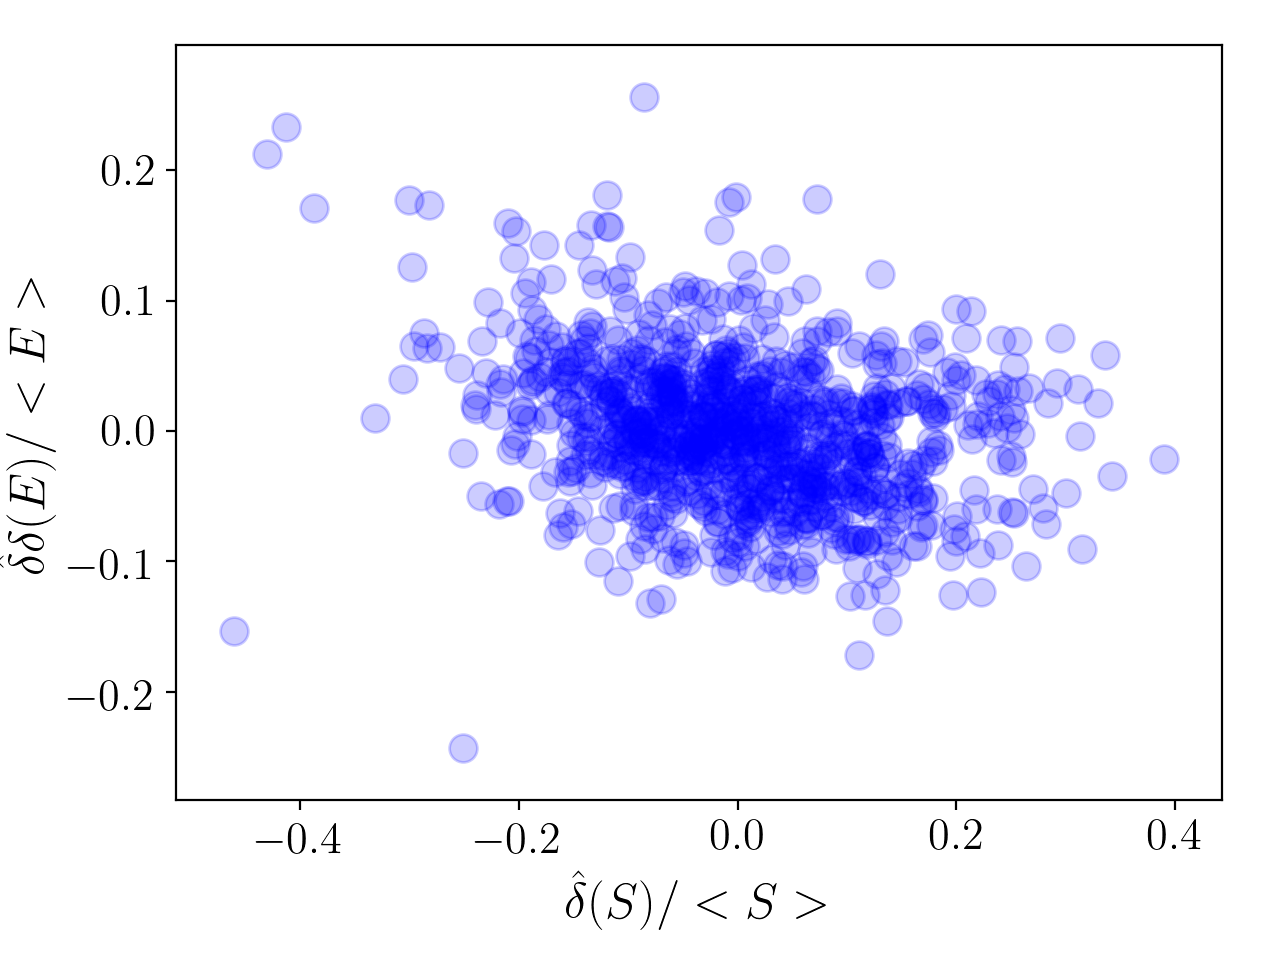

sigma_s/<s> =  0.11985069813693794
<dN_ch/deta> = 4.510511651127049 +/- 0.03588013803671199
Q_dP-dEstTotal= 8.778e-01  +/-  8.624e-03
Q_dP-dEst= 8.651e-01  +/-  1.020e-02
Q_dP-dEst(elliptic area)= 6.312e-01  +/-  4.016e-02
Q_dP-dEst(round area)= 5.790e-01  +/-  4.383e-02
Q_dP-dr2= -7.716e-02  +/-  2.732e-02
Q_dP-d[1/r2]= 6.126e-01  +/-  3.846e-02
Q_dP-denergy(elliptic area)= 6.981e-01  +/-  3.353e-02
Q_dP-denergy= 5.839e-01  +/-  4.745e-02
Q_dP-denergy_nofix= 9.698e-01  +/-  4.250e-03
Q_dP-dEOverS= 8.221e-01  +/-  1.141e-02
Q_dP-dEst= 8.651e-01  +/-  1.020e-02
Q_dpTbar-dE_fixmult= 5.499e-01
Q_dpTbar-dEOverS_fixmult= 8.252e-01
Q_dpTbar-E0/A_fixmult= 6.266e-01
Q_dpTbar-S0/A_fixmult= 5.793e-01
sqrt(<e_p^2>)= 0.036074112875292774 +/- 0.0006347000469767208
sqrt(<v_2^2>)= 0.031476289914549566 +/- 0.000605041292666179
sqrt(<e_2^2>)= 0.5412044699409524 +/- 0.007490594466672168
Pearson e_p v_2= 0.5215027249345227  +/-  0.026916732815246668
Pearson e_2 v_2= 0.48924375652081276  +/-  0.0220391638

In [144]:
#compute Pearson coefficients

deltaN = deltaN_05
deltaNdeltaN_avg = mean(deltaN*deltaN)

ep = array(ep)
ecc_2_ev = array(ecc_2_ev)
ecc_3_ev = array(ecc_3_ev)
ep_real = array(ep_real)
ep_imag = array(ep_imag)

ecc_2_real = array(ecc_2_real)
ecc_2_imag = array(ecc_2_imag)
r_ev = array(r_ev)
r2_ev = array(r2_ev)
energyV = array(energyV)
entropy =array(entropy)
area = array(area)
uT = array(uT)
entropy_density_avg = array(entropy_density_avg)
entropy_density_rms = array(entropy_density_rms)

delta_e22 = ecc_2_ev*ecc_2_ev-mean(ecc_2_ev*ecc_2_ev)
deltae22deltaN_avg = mean(delta_e22*deltaN)
de22_fixmult = delta_e22 - deltae22deltaN_avg/deltaNdeltaN_avg*deltaN
de22_fixmult_avg = sqrt(mean(de22_fixmult**2.))

deltaEst_sPerArea = entropy/(r_ev**2.) - mean(entropy/(r_ev**2.))
deltaEst_sPerAreadeltaN_avg = mean(deltaEst_sPerArea*deltaN)
dEst_sPerArea_fixmult = deltaEst_sPerArea - deltaEst_sPerAreadeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_sPerArea_fixmult_avg = sqrt(mean(dEst_sPerArea_fixmult**2.))

deltaEst_sPerAreaEcc = entropy/(r_ev**2.*sqrt(1.-ecc_2_ev**2.)) - mean(entropy/(r_ev**2.*sqrt(1.-ecc_2_ev**2.)))
deltaEst_sPerAreaEccdeltaN_avg = mean(deltaEst_sPerAreaEcc*deltaN)
dEst_sPerAreaEcc_fixmult = deltaEst_sPerAreaEcc - deltaEst_sPerAreaEccdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_sPerAreaEcc_fixmult_avg = sqrt(mean(dEst_sPerAreaEcc_fixmult**2.))

deltaEst_sPerArea2 = entropy/(r2_ev) - mean(entropy/(r2_ev))
deltaEst_sPerArea2deltaN_avg = mean(deltaEst_sPerArea2*deltaN)
dEst_sPerArea2_fixmult = deltaEst_sPerArea2 - deltaEst_sPerArea2deltaN_avg/deltaNdeltaN_avg*deltaN
dEst_sPerArea2_fixmult_avg = sqrt(mean(dEst_sPerArea2_fixmult**2.))

deltaEst_sPerArea2Ecc = entropy/(r2_ev*sqrt(1.-ecc_2_ev**2.)) - mean(entropy/(r2_ev*sqrt(1.-ecc_2_ev**2.)))
deltaEst_sPerArea2EccdeltaN_avg = mean(deltaEst_sPerArea2Ecc*deltaN)
dEst_sPerArea2Ecc_fixmult = deltaEst_sPerArea2Ecc - deltaEst_sPerArea2EccdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_sPerArea2Ecc_fixmult_avg = sqrt(mean(dEst_sPerArea2Ecc_fixmult**2.))

deltaEst_ePerArea2Ecc = energyV/(r2_ev*sqrt(1.-ecc_2_ev**2.)) - mean(energyV/(r2_ev*sqrt(1.-ecc_2_ev**2.)))
deltaEst_ePerArea2EccdeltaN_avg = mean(deltaEst_ePerArea2Ecc*deltaN)
dEst_ePerArea2Ecc_fixmult = deltaEst_ePerArea2Ecc - deltaEst_ePerArea2EccdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_ePerArea2Ecc_fixmult_avg = sqrt(mean(dEst_ePerArea2Ecc_fixmult**2.))

deltaEst_e = energyV - mean(energyV)
deltaEst_edeltaN_avg = mean(deltaEst_e*deltaN)
dEst_e_fixmult = deltaEst_e - deltaEst_edeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_e_fixmult_avg = sqrt(mean(dEst_e_fixmult**2.))

deltaEst_s = entropy - mean(entropy)
deltaEst_sdeltaN_avg = mean(deltaEst_s*deltaN)
dEst_s_fixmult = deltaEst_s - deltaEst_sdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_s_fixmult_avg = sqrt(mean(dEst_s_fixmult**2.))

deltaEst_EOverS = energyV/entropy - mean(energyV/entropy)
deltaEst_EOverSdeltaN_avg = mean(deltaEst_EOverS*deltaN)
dEst_EOverS_fixmult = deltaEst_EOverS - deltaEst_EOverSdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_EOverS_fixmult_avg = sqrt(mean(dEst_EOverS_fixmult**2.))

deltaEst = entropy_density_avg - mean(entropy_density_avg)
deltaEstdeltaN_avg = mean(deltaEst*deltaN)
dEst_fixmult = deltaEst - deltaEstdeltaN_avg/deltaNdeltaN_avg*deltaN
dEst_fixmult_avg = sqrt(mean(dEst_fixmult**2.))

deltaEst2 = ecc_2_ev*ecc_2_ev-mean(ecc_2_ev*ecc_2_ev)
deltaEst2deltaN_avg = mean(deltaEst2*deltaN)

#dEst3 is dEst's piece that is orthogonal to de22
dEst3_fixmult = dEst_fixmult - de22_fixmult*mean(dEst_fixmult*de22_fixmult)/mean(de22_fixmult**2.) 
dEst3_fixmult_avg = sqrt(mean(dEst3_fixmult**2.))

#dEst2 is de22's piece that is orthogonal to dEst3
dEst2_fixmult = deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN -dEst3_fixmult*mean((deltaEst2 - deltaEst2deltaN_avg/deltaNdeltaN_avg*deltaN)*dEst3_fixmult)/mean(dEst3_fixmult**2.) 
dEst2_fixmult_avg = sqrt(mean(dEst2_fixmult**2.))

REstP = mean(entropy_density_avg*mean_pT_052)/mean(entropy_density_avg)/mean_pT_052
Re2v2 = mean(ecc_2_ev*v2_cut_05_2)/sqrt(mean(v2_cut_05_2**2.))/sqrt(mean(ecc_2_ev**2.))
Re2e2v2v2 = mean(ecc_2_ev*ecc_2_ev*v2_cut_05_2*v2_cut_05_2)/mean(v2_cut_05_2**2.)/mean(ecc_2_ev**2.)
Rde2dv2 = mean(delta_e22*delta_v22)/sqrt(mean(delta_e22**2))/sqrt(mean(delta_v22**2))
Rde2dv2fm = mean(de22_fixmult*dv22_fixmult)/dv22_fixmult_avg/de22_fixmult_avg
RSP = mean(dEst_fixmult*dpT_052_fixmult)/dEst_fixmult_avg/dpT_052_fixmult_avg
RdEstdP = mean(dEst_fixmult*dpT_052_fixmult)/dEst_fixmult_avg/dpT_052_fixmult_avg
RdEst2dP = mean(dEst2_fixmult*dpT_052_fixmult)/dEst2_fixmult_avg/dpT_052_fixmult_avg
RdEstdEst2fm = mean(dEst_fixmult*dEst2_fixmult)/dEst_fixmult_avg/dEst2_fixmult_avg
RdEst3dEst2fm = mean(dEst3_fixmult*dEst2_fixmult)/dEst3_fixmult_avg/dEst2_fixmult_avg
RdEstdEst2 = mean(deltaEst*deltaEst2)/sqrt(mean(deltaEst**2.))/sqrt(mean(deltaEst2**2.))
RdEst2dP = mean(dEst2_fixmult*dpT_052_fixmult)/dEst2_fixmult_avg/dpT_052_fixmult_avg
RdEst3dP = mean(dEst3_fixmult*dpT_052_fixmult)/dEst3_fixmult_avg/dpT_052_fixmult_avg
RdEst3dv2 = mean(dEst3_fixmult*dv22_fixmult)/dv22_fixmult_avg/dEst3_fixmult_avg
RdEst2dv2 = mean(dEst2_fixmult*dv22_fixmult)/dv22_fixmult_avg/dEst2_fixmult_avg

##
dEst_total_fixmult = (RdEst3dP*dEst3_fixmult/dEst3_fixmult_avg) + (RdEst2dP*dEst2_fixmult/dEst2_fixmult_avg)
dEst_total_fixmult_avg = sqrt(mean(dEst_total_fixmult**2.))
##

deltapTbar_05 = mean_pTEv_05 - mean(mean_pTEv_05)
deltapTbar_05deltaN_avg = mean(deltapTbar_05*deltaN)
deltapTbar_05_fixmult = deltapTbar_05 - deltapTbar_05deltaN_avg/deltaNdeltaN_avg*deltaN

deltaP_052 = P_ev_052-mean(P_ev_052) # 0.5-2GeV
deltaP_052deltaN_avg = mean(deltaP_052*deltaN)
deltaP_052_fixmult = deltaP_052 - deltaP_052deltaN_avg/deltaNdeltaN_avg*deltaN

deltaP_05 = P_ev_05-mean(P_ev_05) # 0.-5GeV
deltaP_05deltaN_avg = mean(deltaP_05*deltaN)
deltaP_05_fixmult = deltaP_05 - deltaP_05deltaN_avg/deltaNdeltaN_avg*deltaN

deltar2 = r2_ev - mean(r2_ev)
deltar2deltaN_avg = mean(deltar2*deltaN)
dr2_fixmult = deltar2 - deltar2deltaN_avg/deltaNdeltaN_avg*deltaN
dr2_fixmult_avg = sqrt(mean(dr2_fixmult**2.))

deltainvr2 = 1./r2_ev - mean(1./r2_ev)
deltainvr2deltaN_avg = mean(deltainvr2*deltaN)
dinvr2_fixmult = deltainvr2 - deltainvr2deltaN_avg/deltaNdeltaN_avg*deltaN
dinvr2_fixmult_avg = sqrt(mean(dinvr2_fixmult**2.))

Pearson_total = mean(deltaP_05_fixmult*dEst_total_fixmult)/sqrt(mean(dEst_total_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson = mean(deltaP_05_fixmult*dEst_fixmult)/sqrt(mean(dEst_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_sPerArea2 = mean(deltaP_05_fixmult*dEst_sPerArea2_fixmult)/sqrt(mean(dEst_sPerArea2_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_sPerArea2Ecc = mean(deltaP_05_fixmult*dEst_sPerArea2Ecc_fixmult)/sqrt(mean(dEst_sPerArea2Ecc_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_ePerArea2Ecc = mean(deltaP_05_fixmult*dEst_ePerArea2Ecc_fixmult)/sqrt(mean(dEst_ePerArea2Ecc_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_e = mean(deltaP_05_fixmult*dEst_e_fixmult)/sqrt(mean(dEst_e_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_e_nofix = mean(deltaP_05*deltaEst_e)/sqrt(mean(deltaEst_e**2.)*mean(deltaP_05**2.))
Pearson_e_noefix = mean(deltaP_05_fixmult*deltaEst_e)/sqrt(mean(deltaEst_e**2.)*mean(deltaP_05_fixmult**2.))
Pearson_r2 = mean(deltaP_05_fixmult*dr2_fixmult)/sqrt(mean(dr2_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_invr2 = mean(deltaP_05_fixmult*dinvr2_fixmult)/sqrt(mean(dinvr2_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_EOverS = mean(deltaP_05_fixmult*dEst_EOverS_fixmult)/sqrt(mean(dEst_EOverS_fixmult**2.)*mean(deltaP_05_fixmult**2.))
Pearson_e_pTbar = mean(deltapTbar_05_fixmult*deltaEst_e)/sqrt(mean(deltaEst_e**2.)*mean(deltapTbar_05_fixmult**2.))
Pearson_e_pTbar_fixmult = mean(deltapTbar_05_fixmult*dEst_e_fixmult)/sqrt(mean(dEst_e_fixmult**2.)*mean(deltapTbar_05_fixmult**2.))
Pearson_sPerArea2Ecc_pTbar_fixmult = mean(deltapTbar_05_fixmult*dEst_sPerArea2Ecc_fixmult)/sqrt(mean(dEst_sPerArea2Ecc_fixmult**2.)*mean(deltapTbar_05_fixmult**2.))
Pearson_ePerArea2Ecc_pTbar_fixmult = mean(deltapTbar_05_fixmult*dEst_ePerArea2Ecc_fixmult)/sqrt(mean(dEst_ePerArea2Ecc_fixmult**2.)*mean(deltapTbar_05_fixmult**2.))
Pearson_EOverS_pTbar_fixmult = mean(deltapTbar_05_fixmult*dEst_EOverS_fixmult)/sqrt(mean(dEst_EOverS_fixmult**2.)*mean(deltapTbar_05_fixmult**2.))


#compute jackknife error:
summeTotal=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_total_fixmult,i)
    mean1_i = mean(temp_i)
    summeTotal += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_total_fixmult)/sqrt(mean(dEst_total_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summeTotal *= (float(nev)-1)/float(nev)
errorTotal = sqrt(summeTotal)

summe=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_fixmult,i)
    mean1_i = mean(temp_i)
    summe += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_fixmult)/sqrt(mean(dEst_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe *= (float(nev)-1)/float(nev)
error = sqrt(summe)

summe_sPerArea2=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_sPerArea2_fixmult,i)
    summe_sPerArea2 += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_sPerArea2_fixmult)/sqrt(mean(dEst_sPerArea2_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_sPerArea2 *= (float(nev)-1)/float(nev)
error_sPerArea2 = sqrt(summe_sPerArea2)

summe_sPerArea2Ecc=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_sPerArea2Ecc_fixmult,i)
    summe_sPerArea2Ecc += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_sPerArea2Ecc_fixmult)/sqrt(mean(dEst_sPerArea2Ecc_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_sPerArea2Ecc *= (float(nev)-1)/float(nev)
error_sPerArea2Ecc = sqrt(summe_sPerArea2Ecc)

summe_ePerArea2Ecc=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_ePerArea2Ecc_fixmult,i)
    summe_ePerArea2Ecc += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_ePerArea2Ecc_fixmult)/sqrt(mean(dEst_ePerArea2Ecc_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_ePerArea2Ecc *= (float(nev)-1)/float(nev)
error_ePerArea2Ecc = sqrt(summe_ePerArea2Ecc)

summe_e=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_e_fixmult,i)
    summe_e += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_e_fixmult)/sqrt(mean(dEst_e_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_e *= (float(nev)-1)/float(nev)
error_e = sqrt(summe_e)

summe_EOverS=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dEst_EOverS_fixmult,i)
    summe_EOverS += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dEst_EOverS_fixmult)/sqrt(mean(dEst_EOverS_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_EOverS *= (float(nev)-1)/float(nev)
error_EOverS = sqrt(summe_EOverS)

summe_e_nf=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05,i)
    temp2_i = np.delete(deltaEst_e,i)
    summe_e_nf += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05*deltaEst_e)/sqrt(mean(deltaEst_e**2.)*mean(deltaP_05**2.)))**2.
summe_e_nf *= (float(nev)-1)/float(nev)
error_e_nf = sqrt(summe_e_nf)

summe_e_nef=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(deltaEst_e,i)
    summe_e_nef += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*deltaEst_e)/sqrt(mean(deltaEst_e**2.)*mean(deltaP_05_fixmult**2.)))**2.
summe_e_nef *= (float(nev)-1)/float(nev)
error_e_nef = sqrt(summe_e_nef)

summer2=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dr2_fixmult,i)
    mean1_i = mean(temp_i)
    summer2 += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dr2_fixmult)/sqrt(mean(dr2_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summer2 *= (float(nev)-1)/float(nev)
errorr2 = sqrt(summer2)

summeinvr2=0
for i in range(nev):
    temp1_i = np.delete(deltaP_05_fixmult,i)
    temp2_i = np.delete(dinvr2_fixmult,i)
    mean1_i = mean(temp_i)
    summeinvr2 += (mean(temp1_i*temp2_i)/sqrt(mean(temp1_i**2.)*mean(temp2_i**2.))-mean(deltaP_05_fixmult*dinvr2_fixmult)/sqrt(mean(dinvr2_fixmult**2.)*mean(deltaP_05_fixmult**2.)))**2.
summeinvr2 *= (float(nev)-1)/float(nev)
errorinvr2 = sqrt(summeinvr2)

fig0 = plt.figure()
plt.xlabel(r'$\hat{\delta}(S)/<S>$', fontsize = 18)
plt.ylabel(r'$\hat{\delta}\delta(E)/<E>$', fontsize = 18)
plt.text(1, 0.9, r'', fontsize = 18)
plt.tight_layout()
plt.scatter(dEst_s_fixmult/mean(entropy), dEst_e_fixmult/mean(energyV), color="b", alpha=0.2, marker='o')

sfluc = sqrt(mean(dEst_s_fixmult**2.))/mean(entropy)

print("sigma_s/<s> = ",sfluc)

print("<dN_ch/deta> =",dN_dy_avg,"+/-",dN_dy_avg_err)
print("Q_dP-dEstTotal=","%.3e"%Pearson_total," +/- ", "%.3e"%errorTotal)
print("Q_dP-dEst=","%.3e"%Pearson," +/- ", "%.3e"%error)
print("Q_dP-dEst(elliptic area)=","%.3e"%Pearson_sPerArea2Ecc," +/- ", "%.3e"%error_sPerArea2Ecc)
print("Q_dP-dEst(round area)=","%.3e"%Pearson_sPerArea2," +/- ", "%.3e"%error_sPerArea2)
print("Q_dP-dr2=","%.3e"%Pearson_r2," +/- ", "%.3e"%errorr2)
print("Q_dP-d[1/r2]=","%.3e"%Pearson_invr2," +/- ", "%.3e"%errorinvr2)
print("Q_dP-denergy(elliptic area)=","%.3e"%Pearson_ePerArea2Ecc," +/- ", "%.3e"%error_ePerArea2Ecc)
print("Q_dP-denergy=","%.3e"%Pearson_e," +/- ", "%.3e"%error_e)
print("Q_dP-denergy_nofix=","%.3e"%Pearson_e_nofix," +/- ", "%.3e"%error_e_nf)
print("Q_dP-dEOverS=","%.3e"%Pearson_EOverS," +/- ", "%.3e"%error_EOverS)
print("Q_dP-dEst=","%.3e"%Pearson," +/- ", "%.3e"%error)
#print("Q_dpTbar-dE=","%.3e"%Pearson_e_pTbar)
print("Q_dpTbar-dE_fixmult=","%.3e"%Pearson_e_pTbar_fixmult)
print("Q_dpTbar-dEOverS_fixmult=","%.3e"%Pearson_EOverS_pTbar_fixmult)
print("Q_dpTbar-E0/A_fixmult=","%.3e"%Pearson_ePerArea2Ecc_pTbar_fixmult)
print("Q_dpTbar-S0/A_fixmult=","%.3e"%Pearson_sPerArea2Ecc_pTbar_fixmult)

corr_complex = (v2_real*ep_real + v2_imag*ep_imag)
corr_complex_e2v2 = (v2_real*ecc_2_real + v2_imag*ecc_2_imag)
corr_complex_e2ep = (ep_real*ecc_2_real + ep_imag*ecc_2_imag)

v2_rms = sqrt(mean(v2*v2))
ep_rms = sqrt(mean(ep*ep))
e2_rms = sqrt(mean(ecc_2_ev*ecc_2_ev))

v2_rms_err = sqrt(mean(v2**4.)-mean(v2**2.)**2.)/sqrt(nev)/2./v2_rms
ep_rms_err = sqrt(mean(ep**4.)-mean(ep**2.)**2.)/sqrt(nev)/2./ep_rms
e2_rms_err = sqrt(mean(ecc_2_ev**4.)-mean(ecc_2_ev**2.)**2.)/sqrt(nev)/2./e2_rms

print("sqrt(<e_p^2>)=",ep_rms,"+/-",ep_rms_err)
print("sqrt(<v_2^2>)=",v2_rms,"+/-",v2_rms_err)
print("sqrt(<e_2^2>)=",e2_rms,"+/-",e2_rms_err)

corr_complex_e2v2_02_2 = (v2_real_cut_02_2*ecc_2_real + v2_imag_cut_02_2*ecc_2_imag)
v2_02_2_rms = sqrt(mean(v2_cut_02_2*v2_cut_02_2))
corr_complex_e2v2_05_2 = (v2_real_cut_05_2*ecc_2_real + v2_imag_cut_05_2*ecc_2_imag)
v2_05_2_rms = sqrt(mean(v2_cut_05_2*v2_cut_05_2))
corr_complex_e2v2_1_2 = (v2_real_cut_1_2*ecc_2_real + v2_imag_cut_1_2*ecc_2_imag)
v2_1_2_rms = sqrt(mean(v2_cut_1_2*v2_cut_1_2))

v2_02_2_rms_err = sqrt(mean(v2_cut_02_2**4.)-mean(v2_cut_02_2**2.)**2.)/sqrt(nev)/2./v2_02_2_rms
v2_05_2_rms_err = sqrt(mean(v2_cut_05_2**4.)-mean(v2_cut_05_2**2.)**2.)/sqrt(nev)/2./v2_05_2_rms
v2_1_2_rms_err = sqrt(mean(v2_cut_1_2**4.)-mean(v2_cut_1_2**2.)**2.)/sqrt(nev)/2./v2_1_2_rms

#compute jackknife error:
summe_complex=0
summe_complex_e2v2=0
summe_complex_e2ep=0
summe_complex_e2v2_02_2=0
summe_complex_e2v2_05_2=0
summe_complex_e2v2_1_2=0

for i in range(nev):
    temp_i = np.delete(corr_complex/v2_rms/ep_rms,i)
    mean_i = mean(temp_i)
    summe_complex += (mean_i-mean(corr_complex/v2_rms/ep_rms))**2.
    temp_i = np.delete(corr_complex_e2v2/v2_rms/e2_rms,i)
    mean_i = mean(temp_i)
    summe_complex_e2v2 += (mean_i-mean(corr_complex_e2v2/v2_rms/e2_rms))**2.
    temp_i = np.delete(corr_complex_e2ep/ep_rms/e2_rms,i)
    mean_i = mean(temp_i)
    summe_complex_e2ep += (mean_i-mean(corr_complex_e2ep/ep_rms/e2_rms))**2.
    temp_i = np.delete(corr_complex_e2v2_02_2/v2_02_2_rms/e2_rms,i)
    mean_i = mean(temp_i)
    summe_complex_e2v2_02_2 += (mean_i-mean(corr_complex_e2v2_02_2/v2_02_2_rms/e2_rms))**2.
    temp_i = np.delete(corr_complex_e2v2_05_2/v2_05_2_rms/e2_rms,i)
    mean_i = mean(temp_i)
    summe_complex_e2v2_05_2 += (mean_i-mean(corr_complex_e2v2_05_2/v2_05_2_rms/e2_rms))**2.
    temp_i = np.delete(corr_complex_e2v2_1_2/v2_1_2_rms/e2_rms,i)
    mean_i = mean(temp_i)
    summe_complex_e2v2_1_2 += (mean_i-mean(corr_complex_e2v2_1_2/v2_1_2_rms/e2_rms))**2.
    
summe_complex *= (float(nev)-1)/float(nev)
summe_complex_e2v2 *= (float(nev)-1)/float(nev)
summe_complex_e2ep *= (float(nev)-1)/float(nev)
summe_complex_e2v2_02_2 *= (float(nev)-1)/float(nev)
summe_complex_e2v2_05_2 *= (float(nev)-1)/float(nev)
summe_complex_e2v2_1_2 *= (float(nev)-1)/float(nev)

corr_complex_err = sqrt(summe_complex)
corr_complex_e2v2_err = sqrt(summe_complex_e2v2)
corr_complex_e2ep_err = sqrt(summe_complex_e2ep)
corr_complex_e2v2_02_2_err = sqrt(summe_complex_e2v2_02_2)
corr_complex_e2v2_05_2_err = sqrt(summe_complex_e2v2_05_2)
corr_complex_e2v2_1_2_err = sqrt(summe_complex_e2v2_1_2)


print("Pearson e_p v_2=",mean(corr_complex)/v2_rms/ep_rms," +/- ", corr_complex_err)
print("Pearson e_2 v_2=",mean(corr_complex_e2v2)/v2_rms/e2_rms," +/- ", corr_complex_e2v2_err)
print("Pearson e_2 e_p=",mean(corr_complex_e2ep)/v2_rms/e2_rms," +/- ", corr_complex_e2ep_err)

print("Pearson e_2 v_2 (0.2 < pT < 2 GeV)=",mean(corr_complex_e2v2_02_2)/v2_02_2_rms/e2_rms," +/- ", corr_complex_e2v2_02_2_err)
print("Pearson e_2 v_2 (0.5 < pT < 2 GeV)=",mean(corr_complex_e2v2_05_2)/v2_05_2_rms/e2_rms," +/- ", corr_complex_e2v2_05_2_err)
print("Pearson e_2 v_2 (1.0 < pT < 2 GeV)=",mean(corr_complex_e2v2_1_2)/v2_1_2_rms/e2_rms," +/- ", corr_complex_e2v2_1_2_err)

print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ","%.3e"%Pearson," ", "%.3e"%error, " ", "%.3e"%Pearson_sPerArea2Ecc," ", "%.3e"%error_sPerArea2Ecc, " ","%.3e"%Pearson_sPerArea2," ", "%.3e"%error_sPerArea2, " ","%.3e"%Pearson_r2," ", "%.3e"%errorr2, " ","%.3e"%(mean(corr_complex)/v2_rms/ep_rms)," ", "%.3e"%(corr_complex_err))

print("%.3e"%dN_dy_avg," ", "%.3e"%dN_dy_avg_err, " ","%.3e"%Pearson_e," ", "%.3e"%error_e, " ", "%.3e"%Pearson_EOverS," ", "%.3e"%error_EOverS, " ", "%.3e"%Pearson_ePerArea2Ecc," ", "%.3e"%error_ePerArea2Ecc)




In [134]:
# for pure hydro
centParts=centrality.split('-')
centAvg = (int(centParts[0][1:])+int(centParts[1][:]))/2

file_ck = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/ck-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_ck.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%ck_022+"    "+"%.3e"%errorck_022+"    "+ "%.3e"%ck_052+"    "+"%.3e"%errorck_052+"    "+ "%.3e"%ck_12+"    "+"%.3e"%errorck_12+"\n")
file_ck.close()

file_var = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/var-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_var.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%dv22_022_fixmult_avg**2.+"    "+"%.3e"%dv22_022_err+"    "+"%.3e"%dv22_fixmult_avg**2.+"    "+"%.3e"%dv22_052_err+"    "+"%.3e"%dv22_12_fixmult_avg**2.+"    "+"%.3e"%dv22_12_err+"    "+"%.3e"%dv32_022_fixmult_avg**2.+"    "+"%.3e"%dv32_022_err+"    "+"%.3e"%dv32_fixmult_avg**2.+"    "+"%.3e"%dv32_052_err+"    "+"%.3e"%dv32_12_fixmult_avg**2.+"    "+"%.3e"%dv32_12_err+"\n")
file_var.close()

file_cov = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/cov-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_cov.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%mean(dv22_022_fixmult*dpT_022_fixmult)+"    "+"%.3e"%cov_022_err+"    "+"%.3e"%mean(dv22_fixmult*dpT_052_fixmult)+"    "+"%.3e"%cov_052_err+"    "+"%.3e"%mean(dv22_12_fixmult*dpT_12_fixmult)+"    "+"%.3e"%cov_12_err+"    "+"%.3e"%mean(dv32_022_fixmult*dpT_022_fixmult)+"    "+"%.3e"%cov3_022_err+"    "+"%.3e"%mean(dv32_fixmult*dpT_052_fixmult)+"    "+"%.3e"%cov3_052_err+"    "+"%.3e"%mean(dv32_12_fixmult*dpT_12_fixmult)+"    "+"%.3e"%cov3_12_err+"\n")
file_cov.close()

file_rho = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/rho-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_rho.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+ "%.3e"%dN_dy_avg_err+"    "+"%.3e"%mean(cov_v2sq_pT_022)+"    "+"%.3e"%cov_v2sq_pT_err_022+"    "+"%.3e"%mean(cov_v2sq_pT)+"    "+"%.3e"%cov_v2sq_pT_err+"    "+"%.3e"%mean(cov_v2sq_pT_12)+"    "+"%.3e"%cov_v2sq_pT_err_12+"    "+"%.3e"%mean(cov_e2sq_estimator_simple)+"    "+"%.3e"%cov_e2sq_estimator_simple_err+"    "+"%.3e"%mean(cov_e2sq_estimator_area)+"    "+"%.3e"%cov_e2sq_estimator_area_err+"    "+"%.3e"%mean(cov_epsq_estimator_initial)+"    "+"%.3e"%cov_epsq_estimator_initial_err+"    "+"%.3e"%mean(cov_v3sq_pT_022)+"    "+"%.3e"%cov_v3sq_pT_err_022+"    "+"%.3e"%mean(cov_v3sq_pT)+"    "+"%.3e"%cov_v3sq_pT_err+"    "+"%.3e"%mean(cov_v3sq_pT_12)+"    "+"%.3e"%cov_v3sq_pT_err_12+"    "+"%.3e"%mean(cov_e3sq_estimator_simple)+"    "+"%.3e"%cov_e3sq_estimator_simple_err+"    "+"%.3e"%mean(cov_e3sq_estimator_area)+"    "+"%.3e"%cov_e3sq_estimator_area_err+"\n")
file_rho.close()

e2v2 = (mean(corr_complex_e2v2)/v2_rms/e2_rms)
e2v2err = (corr_complex_e2v2_err)
e2v2_02_2 = (mean(corr_complex_e2v2_02_2)/v2_02_2_rms/e2_rms)
e2v2_02_2_err = (corr_complex_e2v2_02_2_err)
e2v2_05_2 = (mean(corr_complex_e2v2_05_2)/v2_05_2_rms/e2_rms)
e2v2_05_2_err = (corr_complex_e2v2_05_2_err)
e2v2_1_2 = (mean(corr_complex_e2v2_1_2)/v2_1_2_rms/e2_rms)
e2v2_1_2_err = (corr_complex_e2v2_1_2_err)

file_P = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/Pearson-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_P.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%Pearson+"    "+"%.3e"%error+"    "+"%.3e"%Pearson_sPerArea2Ecc+"    "+"%.3e"%error_sPerArea2Ecc+"    "+"%.3e"%Pearson_sPerArea2+"    "+"%.3e"%error_sPerArea2+"    "+"%.3e"%Pearson_r2+"    "+"%.3e"%errorr2+"    "+"%.3e"%(mean(corr_complex)/v2_rms/ep_rms)+"    "+"%.3e"%(corr_complex_err)+"    "+"%.3e"%e2v2+"    "+"%.3e"%e2v2err+"    "+"%.3e"%e2v2_02_2+"    "+"%.3e"%e2v2_02_2_err+"     "+"%.3e"%e2v2_05_2+"     "+"%.3e"%e2v2_05_2_err+"    "+"%.3e"%e2v2_1_2+"    "+"%.3e"%e2v2_1_2_err+"\n")
file_P.close()

file_PE = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/Pearson-Energy-"+system+"-"+energy+"GeV-pureHydro_highstat.dat","a")
file_PE.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%Pearson_e+"    "+"%.3e"%error_e+"    "+"%.3e"%Pearson_EOverS+"    "+"%.3e"%error_EOverS+"    "+"%.3e"%Pearson_ePerArea2Ecc+"    "+"%.3e"%error_ePerArea2Ecc+"\n")
file_PE.close()

In [205]:
centParts=centrality.split('-')
centAvg = (int(centParts[0][1:])+int(centParts[1][:]))/2

file_ck = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/ck-"+system+"-"+energy+"GeV.dat","a")
file_ck.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%ck_022+"    "+"%.3e"%errorck_022+"    "+ "%.3e"%ck_052+"    "+"%.3e"%errorck_052+"    "+ "%.3e"%ck_12+"    "+"%.3e"%errorck_12+"\n")
file_ck.close()

file_var = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/var-"+system+"-"+energy+"GeV.dat","a")
file_var.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%dv22_022_fixmult_avg**2.+"    "+"%.3e"%dv22_022_err+"    "+"%.3e"%dv22_fixmult_avg**2.+"    "+"%.3e"%dv22_052_err+"    "+"%.3e"%dv22_12_fixmult_avg**2.+"    "+"%.3e"%dv22_12_err+"    "+"%.3e"%dv32_022_fixmult_avg**2.+"    "+"%.3e"%dv32_022_err+"    "+"%.3e"%dv32_fixmult_avg**2.+"    "+"%.3e"%dv32_052_err+"    "+"%.3e"%dv32_12_fixmult_avg**2.+"    "+"%.3e"%dv32_12_err+"\n")
file_var.close()

file_cov = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/cov-"+system+"-"+energy+"GeV.dat","a")
file_cov.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%mean(dv22_022_fixmult*dpT_022_fixmult)+"    "+"%.3e"%cov_022_err+"    "+"%.3e"%mean(dv22_fixmult*dpT_052_fixmult)+"    "+"%.3e"%cov_052_err+"    "+"%.3e"%mean(dv22_12_fixmult*dpT_12_fixmult)+"    "+"%.3e"%cov_12_err+"    "+"%.3e"%mean(dv32_022_fixmult*dpT_022_fixmult)+"    "+"%.3e"%cov3_022_err+"    "+"%.3e"%mean(dv32_fixmult*dpT_052_fixmult)+"    "+"%.3e"%cov3_052_err+"    "+"%.3e"%mean(dv32_12_fixmult*dpT_12_fixmult)+"    "+"%.3e"%cov3_12_err+"\n")
file_cov.close()

file_rho = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/rho-"+system+"-"+energy+"GeV.dat","a")
file_rho.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+ "%.3e"%dN_dy_avg_err+"    "+"%.3e"%mean(cov_v2sq_pT_022)+"    "+"%.3e"%cov_v2sq_pT_err_022+"    "+"%.3e"%mean(cov_v2sq_pT)+"    "+"%.3e"%cov_v2sq_pT_err+"    "+"%.3e"%mean(cov_v2sq_pT_12)+"    "+"%.3e"%cov_v2sq_pT_err_12+"    "+"%.3e"%mean(cov_e2sq_estimator_simple)+"    "+"%.3e"%cov_e2sq_estimator_simple_err+"    "+"%.3e"%mean(cov_e2sq_estimator_area)+"    "+"%.3e"%cov_e2sq_estimator_area_err+"    "+"%.3e"%mean(cov_epsq_estimator_initial)+"    "+"%.3e"%cov_epsq_estimator_initial_err+"    "+"%.3e"%mean(cov_v3sq_pT_022)+"    "+"%.3e"%cov_v3sq_pT_err_022+"    "+"%.3e"%mean(cov_v3sq_pT)+"    "+"%.3e"%cov_v3sq_pT_err+"    "+"%.3e"%mean(cov_v3sq_pT_12)+"    "+"%.3e"%cov_v3sq_pT_err_12+"    "+"%.3e"%mean(cov_e3sq_estimator_simple)+"    "+"%.3e"%cov_e3sq_estimator_simple_err+"    "+"%.3e"%mean(cov_e3sq_estimator_area)+"    "+"%.3e"%cov_e3sq_estimator_area_err+"\n")
file_rho.close()

e2v2 = (mean(corr_complex_e2v2)/v2_rms/e2_rms)
e2v2err = (corr_complex_e2v2_err+abs(mean(corr_complex_e2v2)/v2_rms/e2_rms/v2_rms*v2_rms_err)+abs(mean(corr_complex_e2v2)/v2_rms/e2_rms/e2_rms*e2_rms_err))
e2v2_02_2 = (mean(corr_complex_e2v2_02_2)/v2_02_2_rms/e2_rms)
e2v2_02_2_err = (corr_complex_e2v2_02_2_err+abs(mean(corr_complex_e2v2_02_2)/v2_02_2_rms/e2_rms/v2_02_2_rms*v2_02_2_rms_err)+abs(mean(corr_complex_e2v2_02_2)/v2_02_2_rms/e2_rms/e2_rms*e2_rms_err))
e2v2_05_2 = (mean(corr_complex_e2v2_05_2)/v2_05_2_rms/e2_rms)
e2v2_05_2_err = (corr_complex_e2v2_05_2_err+abs(mean(corr_complex_e2v2_05_2)/v2_05_2_rms/e2_rms/v2_05_2_rms*v2_05_2_rms_err)+abs(mean(corr_complex_e2v2_05_2)/v2_05_2_rms/e2_rms/e2_rms*e2_rms_err))
e2v2_1_2 = (mean(corr_complex_e2v2_1_2)/v2_1_2_rms/e2_rms)
e2v2_1_2_err = (corr_complex_e2v2_1_2_err+abs(mean(corr_complex_e2v2_1_2)/v2_1_2_rms/e2_rms/v2_1_2_rms*v2_1_2_rms_err)+abs(mean(corr_complex_e2v2_1_2)/v2_1_2_rms/e2_rms/e2_rms*e2_rms_err))

file_P = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/Pearson-"+system+"-"+energy+"GeV.dat","a")
file_P.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%Pearson+"    "+"%.3e"%error+"    "+"%.3e"%Pearson_sPerArea2Ecc+"    "+"%.3e"%error_sPerArea2Ecc+"    "+"%.3e"%Pearson_sPerArea2+"    "+"%.3e"%error_sPerArea2+"    "+"%.3e"%Pearson_r2+"    "+"%.3e"%errorr2+"    "+"%.3e"%(mean(corr_complex)/v2_rms/ep_rms)+"    "+"%.3e"%(corr_complex_err+abs(mean(corr_complex)/v2_rms/ep_rms/v2_rms*v2_rms_err)+abs(mean(corr_complex)/v2_rms/ep_rms/ep_rms*ep_rms_err))+"    "+"%.3e"%e2v2+"    "+"%.3e"%e2v2err+"    "+"%.3e"%e2v2_02_2+"    "+"%.3e"%e2v2_02_2_err+"     "+"%.3e"%e2v2_05_2+"     "+"%.3e"%e2v2_05_2_err+"    "+"%.3e"%e2v2_1_2+"    "+"%.3e"%e2v2_1_2_err+"\n")
file_P.close()



file_PE = open("/Users/schenke/projects/HYDRO/paper/2020/v2pTsmall/"+system+"-"+energy+"GeV/Pearson-Energy-"+system+"-"+energy+"GeV.dat","a")
file_PE.write(str(centAvg)+"    "+"%.3e"%dN_dy_avg+"    "+"%.3e"%dN_dy_avg_err+"    "+"%.3e"%Pearson_e+"    "+"%.3e"%error_e+"    "+"%.3e"%Pearson_EOverS+"    "+"%.3e"%error_EOverS+"    "+"%.3e"%Pearson_ePerArea2Ecc+"    "+"%.3e"%error_ePerArea2Ecc+"\n")
file_PE.close()